<a href="https://colab.research.google.com/github/RuslanKozlyak/Labs_ITMO/blob/main/VRP_v5_Learning_same_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pip

In [1]:
# !pip install blocksnet -q
!pip install torch_geometric -q
!pip install ortools -q

In [2]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [3]:
!git clone https://github.com/kevin-schumann/VRP-GYM.git

fatal: destination path 'VRP-GYM' already exists and is not an empty directory.


# Imports

In [4]:
# import blocksnet as bn

In [5]:
import random
import pandas as pd
from pprint import pprint
from pathlib import Path
from datetime import datetime
import shutil
import math

In [6]:
import logging
from typing import Tuple
import csv
import logging
import os
import time
from copy import deepcopy
from typing import Tuple

import numpy as np
import torch
import torch.nn as nn
from scipy import stats

import torch
from collections import defaultdict

In [7]:
import matplotlib.colors as mcolors

In [8]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import numpy as np
from typing import Tuple, Union

import numpy as np
from torch.utils.data import DataLoader

# Paths

In [9]:

import os
from pathlib import Path

models_dir = os.path.join("..", "..", "..", "models")
if not Path( models_dir ).exists():
    Path( models_dir ).mkdir(parents=True, exist_ok=True)

data_dir = os.path.join("..", "..", "..", "data")
if not Path( data_dir ).exists():
    Path( data_dir ).mkdir(parents=True, exist_ok=True)

raw_dir = os.path.join( data_dir, "raw" )
if not Path( raw_dir ).exists():
    Path( raw_dir ).mkdir(parents=True, exist_ok=True)

graphs_dir = os.path.join( raw_dir, "graphs" )
if not Path( graphs_dir ).exists():
    Path( graphs_dir ).mkdir(parents=True, exist_ok=True)

synthetic_tasks_dir = os.path.join( raw_dir, "synthetic_tasks" )
if not Path( synthetic_tasks_dir ).exists():
    Path( synthetic_tasks_dir ).mkdir(parents=True, exist_ok=True)

log_dir = os.path.join( data_dir, "logs" )
if not Path( log_dir ).exists():
    Path( log_dir ).mkdir(parents=True, exist_ok=True)

images_dir = os.path.join( raw_dir, "images" )
if not Path( images_dir ).exists():
    Path( images_dir ).mkdir(parents=True, exist_ok=True)

interim_dir = os.path.join( data_dir, "interim" )
if not Path( interim_dir ).exists():
    Path( interim_dir ).mkdir(parents=True, exist_ok=True)

result_dir = os.path.join( data_dir, "result" )
if not Path( result_dir ).exists():
    Path( result_dir ).mkdir(parents=True, exist_ok=True)


# Utils

In [10]:

import pickle

def save(obj, path, verbose=False):
    if verbose:
        print("Saving object to {}".format(path))

    with open(path, "wb") as obj_file:
        pickle.dump( obj, obj_file, protocol=pickle.HIGHEST_PROTOCOL )

    if verbose:
        print("Object saved to {}".format(path))
    pass

def load(path, verbose=False):
    if verbose:
        print("Loading object from {}".format(path))
    with open(path, "rb") as obj_file:
        obj = pickle.load(obj_file)
    if verbose:
        print("Object loaded from {}".format(path))
    return obj



# GraphGenerator

In [11]:
import matplotlib
#matplotlib.use("TkAgg")
import matplotlib.pyplot as plt

import numpy as np
import networkx as nx
from pprint import pprint

class GraphGenerator():
    def __init__(self):
        pass

    def build_graph(self, n, graph_type, layout="kamada-kawai", random_seed=45):

        g_init = None
        if graph_type == "ring": g_init = nx.cycle_graph( n )
        if graph_type == "wheel": g_init = nx.wheel_graph(n)
        if graph_type == "tree": g_init = nx.binomial_tree( n )
        if graph_type == "cube":
            g_init = nx.grid_2d_graph( n, n )
            g_init = self.convert_grid_ids_to_int_( g_init )

        if g_init is None: raise Exception( "Available graph types: ring, wheel, tree, cube" )

        node_positions = None
        if layout == "spring": node_positions = nx.drawing.spring_layout( g_init, seed=random_seed )
        if layout == "kamada-kawai": node_positions = nx.drawing.kamada_kawai_layout(g_init)
        if node_positions is None: raise Exception("Available layouts types: spring, kamada-kawai")

        g = nx.Graph()
        for node_id in node_positions:
            g.add_node( node_id, pos=(node_positions[node_id][0], node_positions[node_id][1]))

        edges_init = []
        for node_id in node_positions:
            current_edges = g_init.edges( node_id )
            for current_edge in current_edges:
                edges_init.append( current_edge )
        g.add_edges_from( edges_init )

        return g

    def convert_grid_ids_to_int_(self, grid_graph):
        int_ids_graph = nx.Graph()

        grid_graph_nodes = list(grid_graph.nodes)
        mapped_node_ids = {}
        for i, node_id in enumerate(grid_graph_nodes):
            mapped_node_ids[node_id] = i
        for node_id in grid_graph_nodes:
            new_node_id = mapped_node_ids[ node_id ]
            int_ids_graph.add_node( new_node_id )

        grid_graph_edges = list( grid_graph.edges.data() )
        for grid_edge in grid_graph_edges:
            new_edge = ( mapped_node_ids[grid_edge[0]], mapped_node_ids[grid_edge[1]] )
            int_ids_graph.add_edge( new_edge[0], new_edge[1] )

        return int_ids_graph


    def plot_graph(self, g, ax=None, with_edge_labels=False, **kwds):

        if ax is None:
            cf = plt.gcf()
        else:
            cf = ax.get_figure()
        cf.set_facecolor("w")
        if ax is None:
            if cf.axes:
                ax = cf.gca()
            else:
                ax = cf.add_axes((0, 0, 1, 1))

        if "with_labels" not in kwds:
            kwds["with_labels"] = "labels" in kwds


        pos = nx.get_node_attributes(g, 'pos')

        if with_edge_labels:
            labels = nx.get_edge_attributes(g, 'weight')
            nx.draw_networkx_edge_labels(g, pos, edge_labels=labels)

        nx.draw_networkx(g, pos=pos, ax=ax, **kwds)

    def alter_graph(self, g,
                    shift=(0.0, 0.0),
                    scale=(1.0, 1.0),
                    rotation_angle=0,
                    noised_nodes_part=0.0,
                    node_noise_strength=0.0,
                    convert_to_int=True,
                    random_seed=45):

        np.random.seed( random_seed )
        node_positions = nx.get_node_attributes( g, "pos" )
        old_x, old_y, new_x, new_y = [], [], [], []
        for node_id in node_positions:
            x = node_positions[node_id][0]
            y = node_positions[node_id][1]

            x = (x + shift[0]) * scale[0]
            y = (y + shift[1]) * scale[1]

            if noised_nodes_part > 0.0 and node_noise_strength > 0.0:
                if np.random.uniform() <= noised_nodes_part:
                    x = x + node_noise_strength * np.random.uniform() * x
                    y = y + node_noise_strength * np.random.uniform() * y

            if rotation_angle > 0:
                rotation_phi = (rotation_angle / 180) * np.pi
                x_rot = x * np.cos( rotation_phi ) - y * np.sin( rotation_phi )
                y_rot = x * np.sin( rotation_phi ) + y * np.cos( rotation_phi )
                old_x.append( x )
                old_y.append( y )
                new_x.append( x_rot )
                new_y.append( y_rot )
                x = x_rot
                y = y_rot

            if convert_to_int:
                x = round( x )
                y = round( y )

            node_positions[node_id] = (x, y)

        if rotation_angle > 0:
            mean_old_x = np.mean(old_x)
            mean_old_y = np.mean(old_y)
            mean_new_x = np.mean(new_x)
            mean_new_y = np.mean(new_y)

            for node_id in node_positions:
                x = node_positions[node_id][0]
                y = node_positions[node_id][1]
                x = x + (mean_old_x - mean_new_x)
                y = y + (mean_old_y - mean_new_y)
                if convert_to_int:
                    x = round(x)
                    y = round(y)
                node_positions[node_id] = (x, y)

        nx.set_node_attributes( g, node_positions, name="pos" )
        return g

    def compose_graphs(self, g_1, g_2, m_routes=1, k_neighbours=1,
                       routes_strategy="global", neighbours_strategy="nearest"):
        """
        Compose 2 graphs into one by building routes from g_1 nodes to g_2 nodes.
        :param g_1:
        :param g_2:
        :param m_routes:
        :param k_neighbours:
        :param routes_strategy: global strategy builds m_routes in total,
        local strategy builds m_routes for each node.
        :param neighbours_strategy: nearest, further, random
        :return:
        """

        g_1_nodes = nx.get_node_attributes(g_1, 'pos')
        g_2_nodes = nx.get_node_attributes(g_2, 'pos')
        g_1_edges = list( g_1.edges.data() )
        g_2_edges = list( g_2.edges.data() )

        # mapping g_2 nodes and edges to new node_ids
        max_g_1_node_id = max( list(g_1_nodes.keys()) )
        g_2_node_mapping = {}
        for i in g_2_nodes.keys():
            g_2_node_mapping[i] = max_g_1_node_id + 1 + i
        #inv_g_2_node_mapping = {v: k for k, v in g_2_node_mapping.items()}

        mapped_g_2_nodes = {}
        for i in g_2_nodes.keys():
            new_node_id = g_2_node_mapping[i]
            mapped_g_2_nodes[ new_node_id ] = g_2_nodes[ i ]

        mapped_g_2_edges = []
        for edge in g_2_edges:
            i, j = edge[0], edge[1]
            i, j = g_2_node_mapping[i], g_2_node_mapping[j]
            new_edge = ( i, j, edge[2] )
            mapped_g_2_edges.append( new_edge )

        # building connection edges between graphs
        graphs_connection_edges = None
        if neighbours_strategy == "nearest":
            pairwise_distances = self.calculate_pairwise_distances_( g_1_nodes, g_2_nodes )
            if routes_strategy == "local":
                graphs_connection_edges = self.build_connection_edges_for_each_node_( pairwise_distances, k_neighbours )
            elif routes_strategy == "global":
                graphs_connection_edges = self.build_global_connection_edges_(pairwise_distances, m_routes, k_neighbours)
            else:
                raise Exception("Available routing_strategy: local, global")
        else:
            raise Exception( "Available neighbours_strategy: nearest" )
        for i in range( len(graphs_connection_edges) ):
            node_1 = graphs_connection_edges[i][0]
            node_2 = graphs_connection_edges[i][1]
            node_2 = g_2_node_mapping[ node_2 ]
            graphs_connection_edges[i] = (node_1, node_2, {})

        # building composed graph
        composed_graph = nx.Graph()
        for node_id in g_1_nodes:
            composed_graph.add_node( node_id, pos=g_1_nodes[node_id] )
        for node_id in mapped_g_2_nodes:
            composed_graph.add_node( node_id, pos=mapped_g_2_nodes[node_id] )
        for edge in g_1_edges:
            composed_graph.add_edge( edge[0], edge[1] )
        for edge in mapped_g_2_edges:
            composed_graph.add_edge( edge[0], edge[1] )
        for edge in graphs_connection_edges:
            composed_graph.add_edge( edge[0], edge[1] )

        return composed_graph

    def build_connection_edges_for_each_node_(self, pairwise_distances, k):

        graphs_connection_edges = []
        for i in range( pairwise_distances.shape[0] ):
            current_distances = pairwise_distances[i]
            k_nearest_node_ids = np.argsort( current_distances )[:k]
            for j in range( k ):
                graphs_connection_edges.append( (i, k_nearest_node_ids[j]) )

        return graphs_connection_edges

    def build_global_connection_edges_(self, pairwise_distances, m, k):
        graphs_connection_edges = []

        mean_k_dists = np.zeros( (pairwise_distances.shape[0]), dtype=np.float64 )
        for i in range(pairwise_distances.shape[0]):
            current_distances = pairwise_distances[i]
            k_nearest_node_ids = np.argsort(current_distances)[:k]
            mean_k_nearest_distance = np.mean( current_distances[ k_nearest_node_ids ] )
            mean_k_dists[i] = mean_k_nearest_distance

        m_nearest_nodes_ids = np.argsort(mean_k_dists)[:m]
        for g_1_node_id in m_nearest_nodes_ids:
            current_distances = pairwise_distances[g_1_node_id]
            k_nearest_node_ids = np.argsort(current_distances)[:k]
            for j in range(k):
                graphs_connection_edges.append((g_1_node_id, k_nearest_node_ids[j]))

        return graphs_connection_edges


    def calculate_pairwise_distances_(self, g_1_nodes, g_2_nodes):
        g_1_nodes_coors = np.zeros((len(g_1_nodes), 2), dtype=np.float64)
        g_2_nodes_coors = np.zeros((len(g_2_nodes), 2), dtype=np.float64)
        pairwise_distances = np.zeros((g_1_nodes_coors.shape[0], g_2_nodes_coors.shape[0]), dtype=np.float64)

        for i, node_id in enumerate(g_1_nodes.keys()):
            current_node_coors = g_1_nodes[node_id]
            g_1_nodes_coors[i][0] = current_node_coors[0]
            g_1_nodes_coors[i][1] = current_node_coors[1]

        for i, node_id in enumerate(g_2_nodes.keys()):
            current_node_coors = g_2_nodes[node_id]
            g_2_nodes_coors[i][0] = current_node_coors[0]
            g_2_nodes_coors[i][1] = current_node_coors[1]

        for i in range(g_1_nodes_coors.shape[0]):
            for j in range(g_2_nodes_coors.shape[0]):
                a = g_1_nodes_coors[i]
                b = g_2_nodes_coors[j]
                pairwise_distances[i][j] = np.linalg.norm(a - b)

        return pairwise_distances

    def init_edge_weights(self, g, round_to = 3):
        """
        init by euclidean distance between nodes
        :param g:
        :return:
        """

        node_positions = nx.get_node_attributes(g, "pos")
        distances_attr = {}
        for node_i in node_positions:
            adj_edges = g.edges(node_i)
            ni_xy = node_positions[node_i]
            for edge in adj_edges:
                nj_xy = node_positions[edge[1]]
                distance = np.sqrt( (nj_xy[0] - ni_xy[0]) ** 2 + (nj_xy[1] - ni_xy[1]) ** 2)
                distance = round( distance, round_to )
                distances_attr[(edge[0], edge[1])] = {"weight": distance}
        nx.set_edge_attributes( g, distances_attr )

        return g

    def build_edge_weight_matrix(self, g, fill_empty_policy = "shortest", make_int = True):
        """
        Build, for example, distance or travel time matrix between nodes
        (depends on the sense of weights of edges).

        :param g:
        :return:
        """

        edge_weights = nx.get_edge_attributes(g, 'weight')
        n = len(g.nodes())
        weight_matrix = np.zeros( shape=(n, n), dtype=np.float64 )
        for edge in edge_weights:
            edge_weight = edge_weights[edge]
            weight_matrix[ edge[0], edge[1] ] = edge_weight
            weight_matrix[ edge[1], edge[0] ] = edge_weight

        for i in range( n ):
            for j in range( n ):
                if i == j: continue
                if weight_matrix[i][j] == 0.0:
                    weight_matrix[i][j] = np.nan

        if fill_empty_policy == "shortest":
            weight_matrix = self.fill_by_shortest_path_( g, weight_matrix )
        elif fill_empty_policy == "sum":
            weight_matrix = self.fill_by_sum_( weight_matrix )
        else:
            raise Exception("Available fill policies: shortest, sum")

        if make_int:
            weight_matrix = weight_matrix.astype( np.int64 )

        weight_matrix = weight_matrix.tolist()

        return weight_matrix

    def fill_by_shortest_path_(self, g, weight_matrix):

        n = len(g.nodes())
        for i in range(n):
            for j in range(n):
                if np.isnan( weight_matrix[i][j] ):
                    shortest_path_len = nx.shortest_path_length( g, source=i, target=j,
                                                             weight="weight", method="dijkstra" )
                    shortest_path_len = round( shortest_path_len )
                    weight_matrix[i][j] = shortest_path_len
                    weight_matrix[j][i] = shortest_path_len

        return weight_matrix

    def fill_by_sum_(self, weight_matrix):
        sum_weight = round( np.nansum( weight_matrix ), 1 )
        n = weight_matrix.shape[0]
        for i in range(n):
            for j in range(n):
                if np.isnan( weight_matrix[i][j] ):
                    weight_matrix[i][j] = sum_weight
                    weight_matrix[j][i] = sum_weight
        return weight_matrix


# DataBuilder Simple

In [12]:

import numpy as np

class DataBuilder_MPPSRP_Simple():
    def __init__(self, weight_matrix,
                 distance_multiplier=1, travel_time_multiplier=60*60,
                 planning_horizon=7,
                 safety_level=0.05, max_level=0.95,
                 initial_inventory_level=0.5, tank_capacity=100,
                 depot_service_time = 15*60, station_service_time=10*60,
                 demand=10, products_count=5,
                 k_vehicles=1, compartments=[5 * [20]],
                 mean_vehicle_speed=60, vehicle_time_windows=[[9*60*60, 18*60*60]],
                 noise_initial_inventory=0.0, noise_tank_capacity=0.0,
                 noise_compartments=0.0, noise_demand=0.0,
                 noise_vehicle_time_windows=0.0,
                 noise_restrictions = 0.0,
                 random_seed=45):

        self.weight_matrix = weight_matrix
        self.distance_multiplier = distance_multiplier
        self.travel_time_multiplier = travel_time_multiplier
        self.planning_horizon = planning_horizon

        self.safety_level = safety_level
        self.max_level = max_level
        self.initial_inventory_level = initial_inventory_level
        self.tank_capacity = tank_capacity
        self.depot_service_time = depot_service_time
        self.station_service_time = station_service_time

        self.demand = demand
        self.products_count = products_count

        self.k_vehicles = k_vehicles
        self.mean_vehicle_speed = mean_vehicle_speed
        self.compartments = compartments
        self.vehicle_time_windows = vehicle_time_windows

        self.noise_initial_inventory = noise_initial_inventory
        self.noise_tank_capacity = noise_tank_capacity
        self.noise_compartments = noise_compartments
        self.noise_demand = noise_demand
        self.noise_vehicle_time_windows = noise_vehicle_time_windows
        self.noise_restrictions = noise_restrictions
        self.random_seed = random_seed

        pass

    def build_data_model(self):

        vehicle_compartments, vehicle_time_windows, vehicle_station_restrictions = self.build_vehicles_data_()
        distance_matrix, travel_time_matrix = self.build_base_matrices_()
        station_data = self.build_station_data_()
        service_times = self.build_service_times_()

        data_model = {}
        data_model["distance_matrix"] = distance_matrix
        data_model["travel_time_matrix"] = travel_time_matrix
        data_model["station_data"] = station_data
        data_model["k_vehicles"] = self.k_vehicles
        data_model["vehicle_compartments"] = vehicle_compartments
        data_model["vehicle_time_windows"] = vehicle_time_windows
        data_model["restriction_matrix"] = vehicle_station_restrictions
        data_model["service_times"] = service_times

        return data_model

    def build_service_times_(self):

        service_times = np.zeros( len(self.weight_matrix), dtype=np.int64 )
        service_times[0] = self.depot_service_time
        service_times[1:] = self.station_service_time

        return service_times

    def build_vehicles_data_(self):

        compartments = np.array( self.k_vehicles * self.compartments, dtype=np.float64)
        compartments_noise = self.noise_compartments * np.random.standard_normal(compartments.shape)
        compartments += compartments_noise * compartments
        compartments = compartments.astype( np.int64 )

        vehicle_time_windows = np.array( self.k_vehicles * self.vehicle_time_windows, dtype=np.float64)
        time_windows_noise = self.noise_vehicle_time_windows * np.random.standard_normal( vehicle_time_windows.shape )
        vehicle_time_windows += time_windows_noise * vehicle_time_windows
        vehicle_time_windows = vehicle_time_windows.astype(np.int64)

        vehicle_station_restrictions = self.k_vehicles * [[1 for i in range( len(self.weight_matrix) )]]
        vehicle_station_restrictions = np.array( vehicle_station_restrictions, dtype=np.int64 )
        for i in range( vehicle_station_restrictions.shape[0] ):
            for j in range( vehicle_station_restrictions.shape[1] ):
                if np.random.random() <= self.noise_restrictions:
                    vehicle_station_restrictions[i][j] = 0

        return compartments, vehicle_time_windows, vehicle_station_restrictions

    def build_station_data_(self):

        station_data = []
        n_stations = len( self.weight_matrix )
        for i in range( 1, n_stations ):
            for j in range( self.products_count ):
                station_data_row = [i, j,
                                    self.safety_level * self.tank_capacity,
                                    self.max_level * self.tank_capacity,
                                    self.initial_inventory_level * self.tank_capacity]
                station_data_row += self.planning_horizon * [self.demand]
                station_data.append( station_data_row )
        station_data = np.array( station_data, dtype=np.float64 )


        tank_capacities = np.zeros( len(station_data[:, 0]), dtype=np.float64 ) + self.tank_capacity
        tank_capacity_noise = self.noise_tank_capacity * np.random.standard_normal( len(station_data[:, 0]) )
        tank_capacities += tank_capacity_noise * tank_capacities
        station_data[:, 2] = self.safety_level * tank_capacities
        station_data[:, 3] = self.max_level * tank_capacities
        station_data[:, 4] = self.initial_inventory_level * tank_capacities

        demand_noise = self.noise_demand * np.random.standard_normal( station_data[:, 5:].shape )
        station_data[:, 5:] += demand_noise * station_data[:, 5:]

        station_data = np.array(station_data, dtype=np.int64)

        return station_data

    def build_base_matrices_(self):

        distance_matrix = np.array( self.weight_matrix )
        distance_matrix *= self.distance_multiplier

        travel_time_matrix = distance_matrix / self.mean_vehicle_speed
        travel_time_matrix *= self.travel_time_multiplier

        distance_matrix = distance_matrix.astype( dtype=np.int64 )
        travel_time_matrix = travel_time_matrix.astype(dtype=np.int64)

        return distance_matrix, travel_time_matrix

# Solver CPSAT

## Utilst

In [13]:
from ortools.sat.python.cp_model import UNKNOWN, MODEL_INVALID, FEASIBLE, INFEASIBLE, OPTIMAL

statuses_dict = {}
statuses_dict[ UNKNOWN ] = "UNKNOWN"
statuses_dict[ MODEL_INVALID ] = "MODEL_INVALID"
statuses_dict[ FEASIBLE ] = "FEASIBLE"
statuses_dict[ INFEASIBLE ] = "INFEASIBLE"
statuses_dict[ OPTIMAL ] = "OPTIMAL"

## Solution

In [14]:

import numpy as np
from tqdm import tqdm

class Solution_MPPSRP_CPSAT():
    def __init__(self, task, solver):

        self.n_nodes = len(task.data_model["distance_matrix"])
        self.k_vehicles = task.data_model["k_vehicles"]
        self.vehicle_compartments = task.data_model["vehicle_compartments"]
        self.max_trips_per_day = task.other_parameters["max_trips_per_day"]
        self.planning_horizon = task.other_parameters["planning_horizon"]
        self.products = task.other_parameters["P"]
        self.safety_levels = task.data_model["station_data"][:, 2]
        self.capacities = task.data_model["station_data"][:, 3]
        self.station_data_dict = task.station_data_dict

        self.task_id = task.task_id
        self.nodes_count = task.nodes_count
        self.solution_values = self.convert_solution_to_dict_( task, solver )
        self.solution_values = self.postprocess_variables_(self.solution_values)
        self.kpi_dict = self.build_kpi_dict_( task )

        pass

    def get_routes_schedule(self):
        routes_schedule = []

        for t in range( self.planning_horizon ):
            routes_schedule.append( [] )
            for k in range( self.k_vehicles ):
                routes_schedule[t].append( [] )

        x = self.solution_values["x"]
        y = self.solution_values["y"]
        q = self.solution_values["q"]
        products = self.products
        for t in range( self.planning_horizon ):
            for k in range( self.k_vehicles ):
                for r in range( self.max_trips_per_day ):
                    if y[k, r, t] == 1:
                        current_route = []
                        delivery_amount = {}
                        depot_id = 0
                        current_node_id = depot_id
                        current_route.append( depot_id )
                        current_node_id = np.argmax(x[t, k, r, current_node_id, :])
                        while current_node_id != depot_id:
                            current_route.append( current_node_id )
                            delivery_amount[ current_node_id ] = {}

                            for p in range(len(products)):
                                true_product_id = products[p]
                                if true_product_id not in delivery_amount[current_node_id].keys():
                                    delivery_amount[current_node_id][true_product_id] = 0

                                for m in range(len(self.vehicle_compartments[k])):
                                    delivery_amount[current_node_id][true_product_id] += q[t, k, r, current_node_id, p, m]

                            current_node_id = np.argmax(x[t, k, r, current_node_id, :])

                        current_route.append( depot_id )
                        current_route = tuple( current_route )
                        routes_schedule[t][k].append( (current_route, delivery_amount) )

        return routes_schedule

    def get_kpis(self):
        return self.kpi_dict

    def build_kpi_dict_(self, task):

        kpi_dict = {}

        kpi_dict["total_travel_distance"] = 0
        kpi_dict["total_travel_time"] = 0
        x = self.solution_values["x"]
        for t in range( self.planning_horizon ):
            for k in range( self.k_vehicles ):
                for r in range( self.max_trips_per_day ):
                    for i in range( self.n_nodes ):
                        for j in range( self.n_nodes ):
                            kpi_dict["total_travel_distance"] += task.data_model["distance_matrix"][i][j] * x[t, k, r, i, j]
                            kpi_dict["total_travel_time"] += task.data_model["travel_time_matrix"][i][j] * x[t, k, r, i, j]

        kpi_dict["average_stock_levels"] = np.zeros( (self.planning_horizon, ), dtype=np.int64 )
        I = self.solution_values["I"]
        for p in range( len(self.products) ):
            for t in range( self.planning_horizon ):
                current_levels = I[:, p, t+1]
                # if product type is absent on a station, then it is always zero. Don't count them.
                avg_nonzero_levels = np.sum( current_levels[ current_levels != 0 ] )
                kpi_dict["average_stock_levels"][t] = avg_nonzero_levels

        kpi_dict["average_stock_levels_percent"] = []
        I = self.solution_values["I"]
        for t in range(self.planning_horizon):
            for station_data_key in self.station_data_dict.keys():
                i = station_data_key[0]
                p = station_data_key[1]
                p_v = task.other_parameters["P_virtual_ids"][p]
                tank_capacity_i = self.station_data_dict[(i, p)]["tank_capacity"]
                current_level = I[i-1, p_v, t+1]
                kpi_dict["average_stock_levels_percent"].append( current_level / tank_capacity_i )
        kpi_dict["average_stock_levels_percent"] = 100 * np.mean( kpi_dict["average_stock_levels_percent"] )

        kpi_dict["dry_runs"] = 0
        for t in range( self.planning_horizon ):
            for station_data_key in self.station_data_dict.keys():
                i = station_data_key[0]
                p = station_data_key[1]
                safety_level_i = self.station_data_dict[ (i, p) ]["safety_level"]
                p_v = task.other_parameters["P_virtual_ids"][p]
                if self.solution_values["I"][i-1, p_v, t] <= safety_level_i:
                    kpi_dict["dry_runs"] += 1

        kpi_dict["average_vehicle_utilization"] = 0
        delivered_amount = 0
        vehicle_capacities = 0
        q = self.solution_values["q"]
        y = self.solution_values["y"]
        for t in range( self.planning_horizon ):
            for k in range( self.k_vehicles ):
                for r in range( self.max_trips_per_day ):
                    if y[k, r, t] == 1:
                        vehicle_capacities += np.sum( task.data_model["vehicle_compartments"][k] )
                        delivered_amount += np.sum( q[t, k, r, :, :, :] )
        kpi_dict["average_vehicle_utilization"] = round( 100 * (delivered_amount / vehicle_capacities), 1 )

        kpi_dict["average_stops_per_trip"] = 0
        y = self.solution_values["y"]
        z = self.solution_values["z"]
        trips_count = 0
        stops_count = 0
        for t in range( self.planning_horizon ):
            for k in range( self.k_vehicles ):
                for r in range( self.max_trips_per_day ):
                    trips_count += y[k, r, t]
                    for i in range( self.n_nodes - 1 ):
                        stops_count += z[k, i, r, t]
        kpi_dict["average_stops_per_trip"] = stops_count / trips_count


        return kpi_dict

    def postprocess_variables_(self, solution_values):
        """
        Mathematical model is correct, but it always leaves ones into x[0][0] that
        leads to always leave ones into all y (staying at the depot looks like a trip with null distance).
        We need y to build routes. Useful trips are only between depot and stations. So clean all
        ones into x[0][0] and fix y values (leave ones in trips between depot and stations).
        :param solution_values:
        :return:
        """

        x = self.solution_values["x"]
        y = self.solution_values["y"]
        for t in range( self.planning_horizon ):
            for k in range( self.k_vehicles ):
                for r in range( self.max_trips_per_day ):
                    x[t, k, r, 0, 0] = 0

                    # if vehicle stays at a depot - set trip indicator to 0
                    sum_x = np.sum( x[t, k, r, :, :] )
                    if sum_x == 0:
                        y[k, r, t] = 0

        return solution_values

    def convert_solution_to_dict_(self, task, solver):
        """
        Extracts solution values from the solver.
        :param task:
        :param solver:
        :return:
        """

        solution_dict = {}

        n_nodes = self.n_nodes
        k_vehicles = self.k_vehicles
        max_trips_per_day = self.max_trips_per_day
        planning_horizon = self.planning_horizon
        products = self.products

        # 1 - if vehicle k drives from i to j in trip r during day t; 0 - otherwise
        solution_dict["x"] = np.zeros(shape=(planning_horizon, k_vehicles, max_trips_per_day,
                                             n_nodes, n_nodes), dtype=np.int64)
        x = task.variables["x"]
        for t in range(planning_horizon):
            for k in range(k_vehicles):
                for r in range(max_trips_per_day):
                    for i in range(n_nodes):
                        for j in range(n_nodes):
                            solution_dict["x"][t, k, r, i, j] = solver.Value( x[(t, k, r, i, j)] )

        # 1 - if vehicle k driving trip r during day t; 0 - otherwise
        solution_dict["y"] = np.zeros(shape=(k_vehicles, max_trips_per_day, planning_horizon), dtype=np.int64)
        y = task.variables["y"]
        for k in range(k_vehicles):
            for r in range(max_trips_per_day):
                for t in range(planning_horizon):
                    solution_dict["y"][k, r, t] = solver.Value( y[(k, r, t)] )

        # 1 - if vehicle k visits station i during trip r on day t; 0 - otherwise
        solution_dict["z"] = np.zeros(shape=(k_vehicles, n_nodes-1, max_trips_per_day, planning_horizon), dtype=np.int64)
        z = task.variables["z"]
        for k in range( k_vehicles ):
            for i in range( 1, n_nodes ):
                for r in range( max_trips_per_day ):
                    for t in range( planning_horizon ):
                        solution_dict["z"][k, i-1, r, t] = solver.Value( z[(k, i, r, t)] )

        # 1 - if product p is loaded into compartment m of vehicle k during trip r on day t
        solution_dict["w"] = np.zeros(shape=(len(products), k_vehicles,
                                             len(task.data_model["vehicle_compartments"][0]),
                                             max_trips_per_day, planning_horizon), dtype=np.int64)
        w = task.variables["w"]
        for p in range( len(products) ):
            for k in range( k_vehicles ):
                for m in range( len(task.data_model["vehicle_compartments"][k]) ):
                    for r in range( max_trips_per_day ):
                        for t in range( planning_horizon ):
                            solution_dict["w"][p, k, m, r, t] = solver.Value( w[(p, k, m, r, t)] )

        # 1 - if trip s is driven after trip r by vehicle k on day t; 0 - otherwise
        solution_dict["u"] = np.zeros(shape=(planning_horizon, k_vehicles,
                                             max_trips_per_day-1, max_trips_per_day-1), dtype=np.int64)
        u = task.variables["u"]
        for t in range(planning_horizon):
            for k in range(k_vehicles):
                for r in range( max_trips_per_day - 1 ):
                    s = r + 1
                    solution_dict["u"][t, k, r, s-1] = solver.Value( u[(t, k, r, s)] )

        # quantity of product p in compartment m of vehicle k delivered to location i during trip r on day t
        solution_dict["q"] = np.zeros(shape=(planning_horizon, k_vehicles, max_trips_per_day,
                                             n_nodes, len(products), len(task.data_model["vehicle_compartments"][0])),
                                      dtype=np.int64)
        q = task.variables["q"]
        for t in range( planning_horizon ):
            for k in range( k_vehicles ):
                for r in range( max_trips_per_day ):
                    for i in range( n_nodes ):
                        for p in range( len(products) ):
                            for m in range(len(task.data_model["vehicle_compartments"][k])):
                                solution_dict["q"][t, k, r, i, p, m] = solver.Value( q[(t, k, r, i, p, m)] )

        # the time vehicle k can start the service at station i during trip r on day t
        solution_dict["S"] = np.zeros(shape=(planning_horizon, k_vehicles, max_trips_per_day, n_nodes), dtype=np.int64)
        S = task.variables["S"]
        for t in range( planning_horizon ):
            for k in range( k_vehicles ):
                for r in range( max_trips_per_day ):
                    for i in range( n_nodes ):
                        solution_dict["S"][t, k, r, i] = solver.Value( S[(t, k, r, i)] )

        # inventory level of product p at station i at the end of day t
        solution_dict["I"] = np.zeros(shape=(n_nodes-1, len(products), planning_horizon+1), dtype=np.int64)
        I = task.variables["I"]
        for i in range( 1, n_nodes ):
            for p in range( len(products) ):
                for t in range( planning_horizon+1 ):
                    solution_dict["I"][i-1, p, t] = solver.Value( I[(i, p, t-1)] )


        return solution_dict

## Task

In [15]:

import numpy as np
from ortools.sat.python import cp_model

class Task_MPPSRP_CPSAT():
    def __init__(self, data_model, task_id):

        self.data_model = data_model
        self.task_id = task_id
        self.solver_name = "CP-SAT"
        self.model = cp_model.CpModel( )
        self.variables = {}
        self.other_parameters = {}
        self.station_data_dict = {}
        self.nodes_count = len(data_model["distance_matrix"])

        pass

## TaskBuilder

In [16]:

import numpy as np
from ortools.sat.python import cp_model

class TaskBuilder_MPPSRP_FullMILP_CPSAT():
    def __init__(self, max_trips_per_day=10, verbose=True):
        """
        Builder for building an MP-PSRP task in the Boers Full MILP formulation (p.34).
        """

        self.max_trips_per_day = max_trips_per_day
        self.verbose = verbose

        pass

    def build_task(self, data_model, task_id=0):

        task = Task_MPPSRP_CPSAT( data_model=data_model,
                                  task_id=task_id )

        self.define_variables_( task )
        self.add_station_inventory_constraints_(task)
        self.add_vehicle_constraints_(task)
        self.add_route_constraints_(task)
        self.add_speed_up_constraints_(task)
        self.add_min_sum_distance_objective_( task )

        return task

    def define_variables_(self, task):

        # Boyers, p.22

        n_nodes = len(task.data_model["distance_matrix"])
        k_vehicles = task.data_model["k_vehicles"]

        task.other_parameters["planning_horizon"] = len( task.data_model["station_data"][0][5:] )
        planning_horizon = task.other_parameters["planning_horizon"]

        # trip ids
        task.other_parameters["max_trips_per_day"] = self.max_trips_per_day
        task.other_parameters["R"] = np.array( [i for i in range( self.max_trips_per_day )], dtype=np.int64 )

        # existing products in station data
        task.other_parameters["P"] = np.unique( task.data_model["station_data"][:, 1] )
        task.other_parameters["P_virtual_ids"] = {}
        task.other_parameters["virtual_p_to_true"] = {}
        products = task.other_parameters["P"]
        for i in range( len(products) ):
            task.other_parameters["P_virtual_ids"][ products[i] ] = i
            task.other_parameters["virtual_p_to_true"][i] = products[i]

        # contains information about station: station_id, real product_id, product levels
        task.station_data_dict = self.build_station_data_dict_( task )

        # 1 - if vehicle k drives from i to j in trip r during day t; 0 - otherwise
        task.variables["x"] = {}
        x = task.variables["x"]
        for t in range(planning_horizon):
            for k in range(k_vehicles):
                for r in range(self.max_trips_per_day):
                    for i in range(n_nodes):
                        for j in range(n_nodes):
                            x[(t, k, r, i, j)] = task.model.NewIntVar(0, 1, "x_{}_{}_{}_{}_{}".format(t, k, r, i, j))


        # 1 - if vehicle k driving trip r during day t; 0 - otherwise
        task.variables["y"] = {}
        y = task.variables["y"]
        for k in range( k_vehicles ):
            for r in range( self.max_trips_per_day ):
                for t in range( planning_horizon ):
                    y[(k, r, t)] = task.model.NewIntVar( 0, 1, "y_{}_{}_{}".format( k, r, t ) )

        # 1 - if vehicle k visits station i during trip r on day t; 0 - otherwise
        task.variables["z"] = {}
        z = task.variables["z"]
        for k in range( k_vehicles ):
            for i in range(1, n_nodes ):
                for r in range( self.max_trips_per_day ):
                    for t in range( planning_horizon ):
                        z[(k, i, r, t)] = task.model.NewIntVar(0, 1, "z_{}_{}_{}_{}".format(k, i, r, t))

        # 1 - if product p is loaded into compartment m of vehicle k during trip r on day t
        task.variables["w"] = {}
        w = task.variables["w"]
        for p in range( len(products) ):
            for k in range( k_vehicles ):
                for m in range( len(task.data_model["vehicle_compartments"][k]) ):
                    for r in range( self.max_trips_per_day ):
                        for t in range( planning_horizon ):
                            w[(p, k, m, r, t)] = task.model.NewIntVar(0, 1, "w_{}_{}_{}_{}".format(p, k, m, r, t))

        # 1 - if trip s is driven after trip r by vehicle k on day t; 0 - otherwise
        task.variables["u"] = {}
        u = task.variables["u"]
        for t in range(planning_horizon):
            for k in range(k_vehicles):
                for r in range( self.max_trips_per_day - 1 ):
                    s = r + 1
                    u[(t, k, r, s)] = task.model.NewIntVar(0, 1, "u_{}_{}_{}_{}".format(t, k, r, s))

        # quantity of product p in compartment m of vehicle k delivered to location i during trip r on day t
        task.variables["q"] = {}
        q = task.variables["q"]
        for t in range( planning_horizon ):
            for k in range( k_vehicles ):
                for r in range(self.max_trips_per_day):
                    for i in range( n_nodes ):
                        for p in range( len(products) ):
                            for m in range( len(task.data_model["vehicle_compartments"][k]) ):
                                q[(t, k, r, i, p, m)] = task.model.NewIntVar(0,
                                                                             task.data_model["vehicle_compartments"][k][m],
                                                                             "q_{}_{}_{}_{}_{}_{}".format(t, k, r, i, p, m))

        # the time vehicle k can start the service at station i during trip r on day t
        vehicle_time_windows = task.data_model["vehicle_time_windows"]
        task.variables["S"] = {}
        S = task.variables["S"]
        for t in range(planning_horizon):
            for k in range( k_vehicles ):
                for r in range( self.max_trips_per_day ):
                    for i in range( n_nodes ):
                        working_start_time = vehicle_time_windows[k][0]
                        working_end_time = vehicle_time_windows[k][1]
                        S[(t, k, r, i)] = task.model.NewIntVar(working_start_time,
                                                               working_end_time,
                                                               "S_{}_{}_{}_{}".format(t, k, r, i))

        # inventory level of product p at station i at the end of day t
        max_inventory_level = np.max( task.data_model["station_data"][:, 3] )
        task.variables["I"] = {}
        I = task.variables["I"]
        for i in range(1, n_nodes):
            for p in range(len(products)):
                for t in range(planning_horizon):
                    I[(i, p, t)] = task.model.NewIntVar(0, 100 * max_inventory_level, "I_{}_{}_{}".format(i, p, t))
        # for constraint (3)
        for i in range(1, n_nodes):
            for p in range(len(products)):
                I[(i, p, -1)] = task.model.NewIntVar(0, 100 * max_inventory_level, "I_{}_{}_{}".format(i, p, -1))


        if self.verbose:
            print("Variables count:")
            total_count = 0
            for variable_name in task.variables.keys():
                current_count = len( task.variables[variable_name].keys() )
                print("{}: {}".format( variable_name, current_count) )
                total_count += current_count
            print("Total: {}".format( total_count ))

        return task

    def build_station_data_dict_(self, task):
        station_data = task.data_model["station_data"]
        station_data_dict = {}
        for i in range(len(station_data)):
            station_id = station_data[i][0]
            product_id = station_data[i][1]
            safety_level = station_data[i][2]
            tank_capacity = station_data[i][3]
            inventory_level = station_data[i][4]
            demands = station_data[i][5:]
            station_data_dict[(station_id, product_id)] = {
                "safety_level": safety_level,
                "tank_capacity": tank_capacity,
                "inventory_level": inventory_level,
                "demands": demands
            }

        return station_data_dict


    def add_min_sum_distance_objective_(self, task):

        n_nodes = len( task.data_model["distance_matrix"] )
        max_trips = len( task.other_parameters["R"] )
        planning_horizon = task.other_parameters["planning_horizon"]
        k_vehicles = task.data_model["k_vehicles"]

        objective_expression = [
            task.data_model["distance_matrix"][i][j] * task.variables["x"][t, k, r, i, j]
            for k in range( k_vehicles )
            for i in range( n_nodes )
            for j in range( n_nodes )
            for r in range( max_trips )
            for t in range( planning_horizon )
        ]

        task.model.Minimize(sum(objective_expression))

        return task

    def add_station_inventory_constraints_(self, task):
        # Boers, p.23, constraints (2)-(5)

        I = task.variables["I"]
        planning_horizon = task.other_parameters["planning_horizon"]
        station_data_dict = task.station_data_dict

        # constraint (2)
        for t in range( planning_horizon ):
            for station_data_key in station_data_dict.keys():
                i = station_data_key[0]
                p = station_data_key[1]
                safety_level_i = station_data_dict[ (i, p) ]["safety_level"]
                p_v = task.other_parameters["P_virtual_ids"][p]
                # Boers doesn't define L in >= L * safety_level_i
                task.model.Add( I[(i, p_v, t)] >= safety_level_i )

        # constraint (3)
        q = task.variables["q"]
        for t in range( planning_horizon ):
            for station_data_key in station_data_dict.keys():
                i = station_data_key[0]
                p = station_data_key[1]
                p_v = task.other_parameters["P_virtual_ids"][p]
                tank_capacity_i = station_data_dict[(i, p)]["tank_capacity"]
                delivered_q = [ q[(t, k, r, i, p_v, m)]
                                for k in range( task.data_model["k_vehicles"] )
                                for m in range( len(task.data_model["vehicle_compartments"][k]) )
                                for r in task.other_parameters["R"]
                            ]
                # Boers doesn't define L in <= L * tank_capacity_i
                task.model.Add( I[(i, p_v, t-1)] + sum( delivered_q ) <= tank_capacity_i )

        # constraint (4)
        for station_data_key in station_data_dict.keys():
            i = station_data_key[0]
            p = station_data_key[1]
            p_v = task.other_parameters["P_virtual_ids"][p]
            inventory_level_i_p = station_data_dict[(i, p)]["inventory_level"]
            # Boers doesn't define L in == L * inventory_level_i_p
            task.model.Add(I[(i, p_v, -1)] == inventory_level_i_p)

        # constraint (5)
        q = task.variables["q"]
        for t in range( planning_horizon ):
            for station_data_key in station_data_dict.keys():
                i = station_data_key[0]
                p = station_data_key[1]
                p_v = task.other_parameters["P_virtual_ids"][p]
                demand_i_p_t = station_data_dict[(i, p)]["demands"][t]
                delivered_q = [q[(t, k, r, i, p_v, m)]
                               for k in range(task.data_model["k_vehicles"])
                               for m in range(len(task.data_model["vehicle_compartments"][k]))
                               for r in task.other_parameters["R"]
                               ]
                # Boers doesn't define L in L * demand_i_p_t
                task.model.Add( I[(i, p_v, t)] == I[(i, p_v, t-1)] + sum( delivered_q ) - demand_i_p_t )

        return task

    def add_vehicle_constraints_(self, task):
        # Boers, p.23, constraints (6)-(12)

        q = task.variables["q"]
        x = task.variables["x"]
        w = task.variables["w"]
        z = task.variables["z"]

        k_vehicles = task.data_model["k_vehicles"]
        n_stations = len(task.data_model["distance_matrix"])
        restriction_matrix = task.data_model["restriction_matrix"]
        planning_horizon = task.other_parameters["planning_horizon"]
        trips = task.other_parameters["R"]
        products = task.other_parameters["P"]

        # # constraint (6)
        # for k in range( k_vehicles ):
        #     for i in range(1, n_stations ):
        #         for t in range( planning_horizon ):
        #             for r in trips:
        #                 task.model.Add( z[(k, i, r, t)] <= restriction_matrix[k][i] )

        # constraint (7)
        for k in range( k_vehicles ):
            for t in range( planning_horizon ):
                for r in trips:
                    task.model.Add( sum(x[(t, k, r, 0, j)] for j in range( n_stations )) == 1 )

        # constraint (8)
        for k in range( k_vehicles ):
            for t in range( planning_horizon ):
                for r in trips:
                    for j in range( n_stations ):
                        in_flow = sum([x[(t, k, r, i, j)] for i in range(n_stations)])
                        out_flow = sum([x[(t, k, r, j, i)] for i in range(n_stations)])
                        task.model.Add(in_flow - out_flow == 0)

        # constraint (9)
        for k in range( k_vehicles ):
            for i in range(1, n_stations ):
                for t in range( planning_horizon ):
                    for r in trips:
                        x_link_to_z = [ x[(t, k, r, i, j)] for j in range( n_stations ) if i != j ]
                        task.model.Add( z[(k, i, r, t)] == sum( x_link_to_z ))

        # constraint (10)
        for i in range(1, n_stations ):
            for k in range( k_vehicles ):
                for m in range( len(task.data_model["vehicle_compartments"][k]) ):
                    for t in range( planning_horizon ):
                        for r in task.other_parameters["R"]:
                            for p in range( len(products) ):
                                # Boers doesn't specify L in <= L * z[(k, i, r, t)]
                                compartment_capacity = task.data_model["vehicle_compartments"][k][m]
                                task.model.Add(q[(t, k, r, i, p, m)] <= compartment_capacity * z[(k, i, r, t)])

        # constraint (11)
        for k in range( k_vehicles ):
            for m in range( len(task.data_model["vehicle_compartments"][k]) ):
                for t in range( planning_horizon ):
                    for r in task.other_parameters["R"]:
                        for p in range( len(products) ):
                            delivered_amount = [q[(t, k, r, i, p, m)] for i in range(1, n_stations )]
                            compartment_capacity = task.data_model["vehicle_compartments"][k][m]
                            task.model.Add(sum( delivered_amount ) <= w[(p, k, m, r, t)] * compartment_capacity)

        # constraint (12)
        for k in range( k_vehicles ):
            for m in range( len(task.data_model["vehicle_compartments"][k]) ):
                for t in range( planning_horizon ):
                    for r in task.other_parameters["R"]:
                        w_expression = [ w[(p, k, m, r, t)] for p in range( len(products) ) ]
                        task.model.Add( sum(w_expression) <= 1)

        return task

    def add_route_constraints_(self, task):

        # Boers, p.23, constraints (13)-(18)

        S = task.variables["S"]
        x = task.variables["x"]
        y = task.variables["y"]
        u = task.variables["u"]
        z = task.variables["z"]

        k_vehicles = task.data_model["k_vehicles"]
        n_stations = len(task.data_model["distance_matrix"])
        planning_horizon = task.other_parameters["planning_horizon"]
        vehicle_time_windows = task.data_model["vehicle_time_windows"]
        travel_time_matrix = task.data_model["travel_time_matrix"]
        service_times = task.data_model["service_times"]

        # constraints (13)-(14)
        # realized into S definition

        # constraint (15)
        sum_travel_time = np.sum( travel_time_matrix )
        for k in range(k_vehicles):
            for r in task.other_parameters["R"]:
                for t in range( planning_horizon ):
                    for i in range(1, n_stations ):
                        for j in range(1, n_stations ):
                            # Boers doesn't define L in L * (1 - x[(t, k, r, i, j)])
                            task.model.Add( S[(t, k, r, i)] + travel_time_matrix[i][j] +
                                            service_times[i] - sum_travel_time * (1 - x[(t, k, r, i, j)]) <= S[(t, k, r, j)])

        # constraint (16)
        sum_travel_time = np.sum(travel_time_matrix)
        for t in range(planning_horizon):
            for k in range(k_vehicles):
                for r in range(len(task.other_parameters["R"]) - 1):
                    s = r + 1
                    # Boers doesn't define L in L * (1 - u[(t, k, r, s)])
                    task.model.Add( S[(t, k, s, 0)] + sum_travel_time * (1 - u[(t, k, r, s)]) >= S[(t, k, r, 0)] )

        # !!!!! My custom constraint !!!!!!!
        # Vehicle can't start a trip at the last second of a working day
        # Vehicle should end a trip before a work day end
        """
        sum_travel_time = np.sum(travel_time_matrix)
        for k in range(k_vehicles):
            for r in task.other_parameters["R"]:
                for t in range(planning_horizon):
                    for i in range(1, n_stations):
                        for j in range(1, n_stations):
                            task.model.Add( S[(t, k, r, i)] + travel_time_matrix[i][j] + travel_time_matrix[j][i] +
                                            service_times[i] - sum_travel_time * (1 - x[(t, k, r, i, j)])
                                            <= vehicle_time_windows[k][1])"""

        # constraint (17)
        for k in range(k_vehicles):
            for t in range(planning_horizon):
                left_part = [ u[(t, k, r, r+1)]
                              for r in range(len(task.other_parameters["R"]) - 1)]
                right_part = [ y[(k, r, t)] for r in range(len(task.other_parameters["R"]))]
                task.model.Add( sum( left_part ) >= sum( right_part ) - 1 )

        # constraint (18)
        for k in range(k_vehicles):
            for t in range(planning_horizon):
                for r in task.other_parameters["R"]:
                    for i in range(1, n_stations ):
                        task.model.Add( z[(k, i, r, t)] <= y[(k, r, t)] )

        return task

    def add_speed_up_constraints_(self, task):
        # Boers, p.25, constraints (27)-(29)

        q = task.variables["q"]
        x = task.variables["x"]
        y = task.variables["y"]
        w = task.variables["w"]

        k_vehicles = task.data_model["k_vehicles"]
        n_stations = len(task.data_model["distance_matrix"])
        planning_horizon = task.other_parameters["planning_horizon"]
        trips = task.other_parameters["R"]
        products = task.other_parameters["P"]

        # constraint (27)
        for t in range( planning_horizon ):
            for k in range( k_vehicles ):
                for r in trips:
                    task.model.Add( sum([x[t, k, r, i, 0] for i in range(n_stations)]) == 1 )

        # constraint (28)
        for t in range( planning_horizon ):
            for k in range( k_vehicles ):
                for r in trips:
                    for i in range(n_stations):
                        for j in range(n_stations):
                            task.model.Add( x[t, k, r, i, j] <= y[k, r, t] )

        # constraint (29)
        for t in range( planning_horizon ):
            for k in range( k_vehicles ):
                for r in trips:
                    for m in range(len(task.data_model["vehicle_compartments"][k])):
                        for p in range(len(products)):
                            for i in range(n_stations):
                                # Boers doesn't define L in <= L * w[(p, k, m, r, t)]
                                compartment_size = task.data_model["vehicle_compartments"][k][m]
                                task.model.Add(q[(t, k, r, i, p, m)] <= compartment_size * w[(p, k, m, r, t)])

        return task

## TaskSolver

In [17]:

import numpy as np
from datetime import datetime

from ortools.sat.python import cp_model
from ortools.sat import cp_model_pb2
from pathlib import Path

class TaskSolver_MPPSRP_CPSAT():
    def __init__(self, cache_dir=None,
                 cache_all_feasible_solutions=False,
                 solution_prefix=None,
                 time_limit_milliseconds = None):

        self.solver = cp_model.CpSolver()
        self.cache_dir = cache_dir
        self.solution_prefix = solution_prefix
        self.cache_all_feasible_solutions = cache_all_feasible_solutions
        self.time_limit_milliseconds = time_limit_milliseconds

        pass

    def solve(self, task):

        if self.time_limit_milliseconds is not None:
            self.solver.parameters.max_time_in_seconds = self.time_limit_milliseconds / 1000.0

        status = self.solver.Solve( task.model, self.SolutionLogger( task, self.cache_dir,
                                                                     self.cache_all_feasible_solutions,
                                                                     self.solution_prefix) )
        status = statuses_dict[ status ]

        solution = None
        if status in ["OPTIMAL", "FEASIBLE"]:
            print(status)
            solution = Solution_MPPSRP_CPSAT(task, self.solver)
        else:
            print("Status: {}".format( status ))

        return solution

    class SolutionLogger(cp_model.CpSolverSolutionCallback):
        """Display the objective value and time of intermediate solutions."""

        def __init__(self, task, cache_dir = None,
                     cache_all_feasible_solutions = True,
                     solution_prefix=None):
            cp_model.CpSolverSolutionCallback.__init__(self)

            self.task = task
            self.cache_dir = cache_dir
            self.solution_prefix = solution_prefix
            self.cache_all_feasible_solutions = cache_all_feasible_solutions

            self.solutions_count = 0
            self.best_objective = 10**9
            self.start_time = datetime.now()

        def on_solution_callback(self) -> None:
            """Called on each new solution."""
            current_time = datetime.now()
            objective_value = self.ObjectiveValue()
            print( "Solution: {} | Objective value: {} | "
                   "Solving time: {} | Datetime: {}".format( self.solutions_count,
                                                            objective_value,
                                                            current_time - self.start_time,
                                                            current_time) )
            if self.cache_dir is not None:
                solution_to_cache = Solution_MPPSRP_CPSAT(self.task, self)

                if self.solution_prefix is None:
                    self.solution_prefix = "solution"

                if self.cache_all_feasible_solutions:
                    save( solution_to_cache,
                          Path( self.cache_dir, self.solution_prefix + "_" + "{}.pkl".format(self.solutions_count) ),
                          verbose=False )

                if objective_value < self.best_objective:
                    self.best_objective = objective_value

                    save( solution_to_cache,
                          Path(self.cache_dir, self.solution_prefix + "_" + "best.pkl"),
                          verbose=False )

            self.solutions_count += 1

        def solution_count(self) -> int:

            return self.solutions_count

# Scripts

## Graph Generator

### Wheel Prime

done


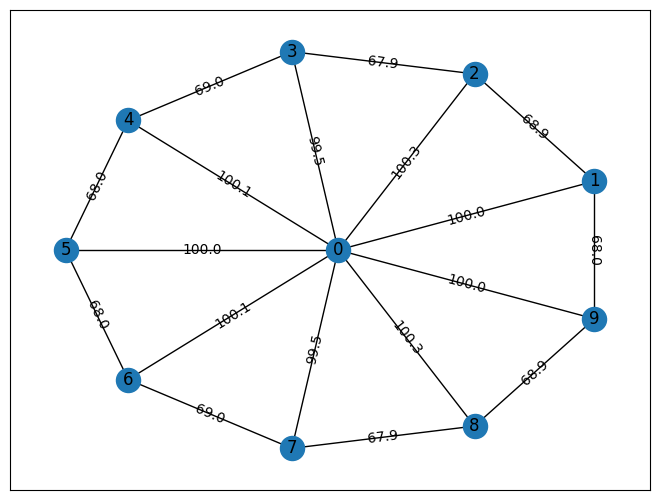

In [18]:
import matplotlib
#matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
from pprint import pprint

graph_generator = GraphGenerator()

g = graph_generator.build_graph( 10, graph_type="wheel", layout="kamada-kawai")
g = graph_generator.alter_graph( g, shift=(1.3, 1.3), scale=(100.0, 100.0), rotation_angle=0, convert_to_int=True )
g = graph_generator.init_edge_weights( g, round_to = 1 )
weight_matrix = graph_generator.build_edge_weight_matrix(g, fill_empty_policy ="shortest", make_int=True)


dataset_name = "wheel_prime_10"
graph_generator.plot_graph( g, with_labels=True, with_edge_labels=True )
#plt.show()
plt.savefig( Path( images_dir, "{}.jpg".format( dataset_name ) ), dpi=1000 )
graph_data = {}
graph_data["graph"] = g
graph_data["weight_matrix"] = weight_matrix
save( graph_data, Path(graphs_dir, "{}.pkl".format( dataset_name ) ))

print("done")

In [19]:
# graph_generator = GraphGenerator()

# g = graph_generator.build_graph( 5, graph_type="tree", layout="kamada-kawai")
# g = graph_generator.alter_graph( g, shift=(1.0, 1.0), scale=(100.0, 100.0), rotation_angle=0, convert_to_int=True )

# composed_graph = graph_generator.init_edge_weights( g, round_to=1 )
# weight_matrix = graph_generator.build_edge_weight_matrix(composed_graph, fill_empty_policy="shortest")

# dataset_name = "tree_prime_5"
# graph_generator.plot_graph( composed_graph, with_labels=True, with_edge_labels=False,
#                             node_size=20, font_size=8)
# #plt.show()
# plt.savefig( Path( images_dir, "{}.jpg".format( dataset_name ) ), dpi=1000 )
# graph_data = {}
# graph_data["graph"] = composed_graph
# graph_data["weight_matrix"] = weight_matrix
# save( graph_data, Path( graphs_dir, "{}.pkl".format( dataset_name ) ))

# print("done")

In [20]:
# graph_generator = GraphGenerator()

# g_2 = graph_generator.build_graph( 10, graph_type="wheel", layout="kamada-kawai")
# g_2 = graph_generator.alter_graph( g_2, shift=(1.3, 1.3), scale=(100.0, 100.0), rotation_angle=0, convert_to_int=True )

# g_3 = graph_generator.build_graph( 20, graph_type="ring", layout="kamada-kawai")
# g_3 = graph_generator.alter_graph( g_3, shift=(1.0, 1.0), scale=(130.0, 130.0), rotation_angle=0, convert_to_int=True )

# g = graph_generator.compose_graphs( g_2, g_3, m_routes=4, k_neighbours=2,
#                                     routes_strategy="global", neighbours_strategy="nearest" )
# g = graph_generator.init_edge_weights( g, round_to = 1 )
# weight_matrix = graph_generator.build_edge_weight_matrix(g, fill_empty_policy="shortest")


# dataset_name = "wheel_10_ring_20"
# graph_generator.plot_graph( g, with_labels=True, with_edge_labels=True )
# #plt.show()
# plt.savefig( Path( images_dir, "{}.jpg".format( dataset_name ) ), dpi=1000 )
# graph_data = {}
# graph_data["graph"] = g
# graph_data["weight_matrix"] = weight_matrix
# save( graph_data, Path( graphs_dir, "{}.pkl".format( dataset_name ) ))

# print("done")

### Graph generator

In [21]:
def create_wheel_noised(num_nodes):
  graph_generator = GraphGenerator()

  g = graph_generator.build_graph( num_nodes, graph_type="wheel", layout="kamada-kawai")
  g = graph_generator.alter_graph( g, shift=(1.3, 1.3), scale=(100.0, 100.0), rotation_angle=0, convert_to_int=True,
                                  noised_nodes_part=0.8, node_noise_strength=0.2, random_seed=random.randint(0,100000))
  g = graph_generator.init_edge_weights( g, round_to = 1 )
  weight_matrix = graph_generator.build_edge_weight_matrix(g, fill_empty_policy ="shortest", make_int=True)

  graph_data = {}
  graph_data["graph"] = g
  graph_data["weight_matrix"] = weight_matrix
  return graph_data

In [22]:
def create_tree_noised(num_nodes):

  graph_generator = GraphGenerator()

  g = graph_generator.build_graph( num_nodes, graph_type="tree", layout="spring", random_seed=random.randint(0,100000))
  g = graph_generator.alter_graph( g, shift=(1.0, 1.0), scale=(100.0, 100.0), rotation_angle=0, convert_to_int=True )
  g = graph_generator.alter_graph( g, shift=(1.0, 1.0), scale=(1.0, 1.0),
                                  noised_nodes_part=1.0, node_noise_strength=0.1, random_seed=random.randint(0,100000),
                                  rotation_angle=0, convert_to_int=True )
  g = graph_generator.alter_graph( g, shift=(1.0, 1.0), scale=(1.0, 1.0),
                                  noised_nodes_part=0.4, node_noise_strength=0.2, random_seed=random.randint(0,100000),
                                  rotation_angle=0, convert_to_int=True )

  composed_graph = graph_generator.init_edge_weights( g, round_to=1 )
  weight_matrix = graph_generator.build_edge_weight_matrix(composed_graph, fill_empty_policy="shortest")

  graph_data = {}
  graph_data["graph"] = composed_graph
  graph_data["weight_matrix"] = weight_matrix

  return graph_data

In [23]:
def create_grid_noised(num_nodes):
  graph_generator = GraphGenerator()

  g = graph_generator.build_graph( num_nodes, graph_type="cube", layout="kamada-kawai" )
  g = graph_generator.alter_graph( g, shift=(1.0, 1.0), scale=(100.0, 100.0), rotation_angle=0, convert_to_int=True )
  g = graph_generator.alter_graph( g, shift=(1.0, 1.0), scale=(1.0, 1.0),
                                  noised_nodes_part=1.0, node_noise_strength=0.05, random_seed=45,
                                  rotation_angle=0, convert_to_int=True )
  g = graph_generator.alter_graph( g, shift=(1.0, 1.0), scale=(1.0, 1.0),
                                  noised_nodes_part=0.2, node_noise_strength=0.2, random_seed=46,
                                  rotation_angle=0, convert_to_int=True )

  g = graph_generator.init_edge_weights( g, round_to = 3 )
  weight_matrix = graph_generator.build_edge_weight_matrix(g, fill_empty_policy="shortest")

  graph_data = {}
  graph_data["graph"] = g
  graph_data["weight_matrix"] = weight_matrix

  return graph_data

### Generate Dataset

In [24]:
def get_graph_dict(synth_data,
                   num_nodes,
                   products_count,
                   compartment_capacity,
                   planning_horizon,
                   noise_demand,
                   num_depots=1,
                   k_vehicles=1,
                   draw=False):
    data_builder = DataBuilder_MPPSRP_Simple(synth_data["weight_matrix"],
                                         distance_multiplier=1, travel_time_multiplier=60*60,
                                         planning_horizon=planning_horizon,
                                         safety_level=0.05, max_level=0.95,
                                         initial_inventory_level=0.5, tank_capacity=100,
                                         depot_service_time = 0*60, station_service_time=0*60,
                                         demand=10, products_count=products_count,
                                         k_vehicles=k_vehicles, compartments=[products_count * [compartment_capacity]],
                                         mean_vehicle_speed=60, vehicle_time_windows=[[9*60*60, 18*60*60]],
                                         noise_initial_inventory=0.0, noise_tank_capacity=0.0,
                                         noise_compartments=0.0, noise_demand=noise_demand,
                                         noise_vehicle_time_windows=0.0,
                                         noise_restrictions = 0.0,
                                         random_seed=45)

    graph_data = data_builder.build_data_model()
    if draw:
      graph_generator.plot_graph( synth_data['graph'], with_labels=True, with_edge_labels=True )

    # get node position
    graph = synth_data['graph']
    positions = nx.get_node_attributes(graph, 'pos').values()
    positions = np.asarray(list(positions))

    # get depots
    depots = np.array([0]) #np.random.choice(num_nodes, size=num_depots, replace=False)

    # get and normalize weight matrix
    weight_matrix = graph_data['travel_time_matrix']
    #weight_matrix = (weight_matrix-weight_matrix.min())/(weight_matrix.max()-weight_matrix.min())

    # get demands and normalize by compartment_capacity
    plan_horizon_prods = []
    min_capacities = []
    max_capacities = []
    init_capacities = []
    for day_num in range(planning_horizon):

      #demands
      demand_idx = 5
      prods = []
      for i in range(products_count):
        products_type_mask = graph_data['station_data'][:,1] == i
        demands = graph_data['station_data'][products_type_mask][:, demand_idx + day_num]
        demands = np.insert(demands, 0, 0)
        demands = demands / compartment_capacity
        prods.append(demands)
      prods = np.stack(prods, axis=0).T
      plan_horizon_prods.append(prods)

    for i in range(products_count):
      products_type_mask = graph_data['station_data'][:,1] == i
      #min_capacities
      min_cap_idx = 2
      min_capacitie = graph_data['station_data'][products_type_mask][:, min_cap_idx]
      min_capacitie = np.insert(min_capacitie, 0, 0)
      min_capacitie = min_capacitie / compartment_capacity
      min_capacities.append(min_capacitie)

      #max_capacities
      max_cap_idx = 3
      max_capacitie = graph_data['station_data'][products_type_mask][:, max_cap_idx]
      max_capacitie = np.insert(max_capacitie, 0, 0)
      max_capacitie = max_capacitie / compartment_capacity
      max_capacities.append(max_capacitie)

      #init_capacities
      init_cap_idx = 4
      init_capacitie = graph_data['station_data'][products_type_mask][:, init_cap_idx]
      init_capacitie = np.insert(init_capacitie, 0, 0)
      init_capacitie = init_capacitie / compartment_capacity
      init_capacities.append(init_capacitie)


    max_capacities = np.stack(max_capacities, axis=0).T
    min_capacities = np.stack(min_capacities, axis=0).T
    init_capacities = np.stack(init_capacities, axis=0).T

    time_windows = graph_data['vehicle_time_windows']
    time_deltas = time_windows[:,1] - time_windows[:,0]
    time_deltas = time_deltas * planning_horizon

    model_for_nn = {
        'positions':positions,
        'travel_time_matrix':weight_matrix,
        'node_demand':np.array(plan_horizon_prods),
        'products_count':products_count,
        'compartment_capacity':compartment_capacity,
        'num_nodes':num_nodes,
        'depots':depots,
        'k_vehicles':k_vehicles,
        'vehicle_time_windows':time_deltas,
        'restriction_matrix':graph_data['restriction_matrix'],
        'service_times':graph_data['service_times'],
        'min_capacities':min_capacities,
        'max_capacities':max_capacities,
        'init_capacities':init_capacities,
    }

    return model_for_nn, graph_data

In [25]:
def generate_dataset(graph_creation_method,
                     num_nodes,
                     num_graphs,
                     products_count,
                     num_depots=1,
                     k_vehicles=2,
                     compartment_capacity=50,
                     planning_horizon=1,
                     noise_demand=0.2,
                     dataset_name=None,
                     dataset_dir='/content/drive/MyDrive/GraphDataset',
                     draw=False,
                     del_previous_dir=False,
                     generating_same_graph=True):

  if del_previous_dir:
    shutil.rmtree(dataset_dir, ignore_errors=True)

  if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

  if dataset_name == None:
    dataset_name = f'{graph_creation_method.__name__}_{num_nodes}'

  if generating_same_graph:
    synth_data = graph_creation_method(num_nodes)
    model_for_nn, model_for_cpsat = get_graph_dict(synth_data=synth_data,
                                     num_nodes=num_nodes,
                                     products_count=products_count,
                                     compartment_capacity=compartment_capacity,
                                     noise_demand=noise_demand,
                                     planning_horizon=planning_horizon, draw=draw)
    for idx in tqdm(range(num_graphs)):
      save( model_for_nn, Path(dataset_dir, f"{dataset_name}_{idx}.pkl"))
    return model_for_cpsat
  else:
    for idx in tqdm(range(num_graphs)):
      synth_data = graph_creation_method(num_nodes)
      model_for_nn, _ = get_graph_dict(synth_data=synth_data,
                                      num_nodes=num_nodes,
                                      products_count=products_count,
                                      compartment_capacity=compartment_capacity,
                                      noise_demand=noise_demand,
                                      planning_horizon=planning_horizon, draw=draw)

      save( model_for_nn, Path(dataset_dir, f"{dataset_name}_{idx}.pkl"))

In [26]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

class CustomImageDataset(Dataset):
    def __init__(self, dataset_dir,
                 generation_function,
                 num_nodes,
                 num_graphs,
                 compartment_capacity,
                 planning_horizon,
                 noise_demand,
                 num_depots,
                 k_vehicles,
                 products_count):

      self.dataset_dir = dataset_dir
      self.num_nodes = num_nodes
      self.num_graphs = num_graphs
      self.compartment_capacity = compartment_capacity
      self.planning_horizon = planning_horizon
      self.num_depots = num_depots
      self.k_vehicles = k_vehicles
      self.products_count = products_count

      self.model_for_cpsat = generate_dataset(create_wheel_noised,
                 num_nodes=num_nodes,
                 num_graphs=num_graphs,
                 compartment_capacity=compartment_capacity,
                 products_count=products_count,
                 planning_horizon=planning_horizon,
                 noise_demand=noise_demand,
                 num_depots=num_depots,
                 k_vehicles=k_vehicles,
                 dataset_dir = dataset_dir,
                 del_previous_dir=True,
                 generating_same_graph=True)

      self.graphs = os.listdir(dataset_dir)

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        file = self.graphs[idx]
        graph = load(Path(self.dataset_dir, file))

        return graph['positions'],\
          graph['travel_time_matrix'], \
          graph['node_demand'],\
          graph['depots'],\
          graph['vehicle_time_windows'],\
          graph['restriction_matrix'],\
          graph['service_times'],\
          graph['min_capacities'],\
          graph['max_capacities'],\
          graph['init_capacities']

## Path drawer

In [27]:
def draw_paths(data_nn, routes):
  G = nx.Graph()
  edges = []
  for r in routes:
      route_edges = [(r[n],r[n+1]) for n in range(len(r)-1)]
      G.add_nodes_from(r)
      G.add_edges_from(route_edges)
      edges.append(route_edges)

  print("Graph has %d nodes with %d edges" %(G.number_of_nodes(),
  G.number_of_edges()))

  pos = data_nn['positions']
  nx.draw_networkx_nodes(G,pos=pos)
  nx.draw_networkx_labels(G,pos=pos)
  colors = list(mcolors.TABLEAU_COLORS.keys())
  for ctr, edgelist in enumerate(edges):
      nx.draw_networkx_edges(G,pos=pos,edgelist=edgelist,edge_color = colors[ctr % len(colors)], width=5)
  plt.savefig('this.png')

## Extract paths

### From nn predictions

In [28]:
def divide_to_paths_nn(actions):

  particular_value = 0
  result = []
  temp_list = []
  for i in actions:
      if i == particular_value:
          temp_list.append(i)
          result.append(temp_list)
          temp_list.insert(0,0)
          temp_list = []
      else:
          temp_list.append(i)
  result.append(temp_list)
  result.pop(0)
  result.pop(-1)
  return result

### From cpsat prediction

In [29]:
def divide_to_path_cpsat(routes_schedule):
  result_paths = []
  for car in routes_schedule[0]:
    for e in car:
      result_paths.append(e[0])
  return result_paths

## CPSAT

In [30]:
products_count = 3
compartment_capacity = 50

In [31]:
from pprint import pprint
from pathlib import Path
from datetime import datetime

dataset_name = "wheel_prime_10"
#dataset_name = "wheel_noised_10"
#dataset_name = "wheel_prime_21"
#dataset_name = "wheel_noised_21"
#dataset_name = "wheel_10_ring_20"
#dataset_name = "grid_noised_49"
#dataset_name = "grid_noised_64"
#dataset_name = "tree_prime_4"
#dataset_name = "tree_prime_5"
#dataset_name = "tree_noised_5"
#dataset_name = "mix_prime_78"
#dataset_name = "mix_noised_78"
#dataset_name = "moskow_prime_248"
#dataset_name = "moskow_noised_248"
#dataset_name = "moskow_prime_380"
#dataset_name = "moskow_noised_380"
synth_data = load( Path( graphs_dir, "{}.pkl".format( dataset_name )))

data_builder = DataBuilder_MPPSRP_Simple(synth_data["weight_matrix"],
                                         distance_multiplier=1, travel_time_multiplier=60*60,
                                         planning_horizon=3,
                                         safety_level=0.05, max_level=0.95,
                                         initial_inventory_level=0.5, tank_capacity=100,
                                         depot_service_time = 0*60, station_service_time=0*60,
                                         demand=10, products_count=2,
                                         k_vehicles=2, compartments=[3 * [compartment_capacity]],
                                         mean_vehicle_speed=60, vehicle_time_windows=[[9*60*60, 18*60*60]],
                                         noise_initial_inventory=0.0, noise_tank_capacity=0.2,
                                         noise_compartments=0.0, noise_demand=0.2,
                                         noise_vehicle_time_windows=0.2,
                                         noise_restrictions = 0.0,
                                         random_seed=45)
data_model = data_builder.build_data_model()

# task_builder = TaskBuilder_MPPSRP_FullMILP_CPSAT( max_trips_per_day=100, verbose=True )
# task = task_builder.build_task( data_model )

# print("Dataset name: {}".format( dataset_name ))
# print("Solving start time: {}".format( datetime.now() ))
# task_solver = TaskSolver_MPPSRP_CPSAT( cache_dir=interim_dir,
#                                        cache_all_feasible_solutions=False,
#                                        solution_prefix=dataset_name,
#                                        time_limit_milliseconds=120_000 )
# solution = task_solver.solve( task )

# print('kpi')
# kpi_dict = solution.get_kpis()
# pprint( kpi_dict )

# print()
# routes_schedule = solution.get_routes_schedule()
# pprint( routes_schedule )

# print("done")

In [32]:
data_model

{'distance_matrix': array([[  0, 100, 100,  99, 100, 100, 100,  99, 100, 100],
        [100,   0,  68, 137, 200, 200, 200, 200, 137,  68],
        [100,  68,   0,  67, 137, 200, 200, 200, 201, 137],
        [ 99, 137,  67,   0,  69, 137, 200, 199, 200, 200],
        [100, 200, 137,  69,   0,  68, 136, 200, 200, 200],
        [100, 200, 200, 137,  68,   0,  68, 137, 200, 200],
        [100, 200, 200, 200, 136,  68,   0,  69, 137, 200],
        [ 99, 200, 200, 199, 200, 137,  69,   0,  67, 137],
        [100, 137, 201, 200, 200, 200, 137,  67,   0,  68],
        [100,  68, 137, 200, 200, 200, 200, 137,  68,   0]]),
 'travel_time_matrix': array([[    0,  6000,  6000,  5940,  6000,  6000,  6000,  5940,  6000,
          6000],
        [ 6000,     0,  4080,  8220, 12000, 12000, 12000, 12000,  8220,
          4080],
        [ 6000,  4080,     0,  4020,  8220, 12000, 12000, 12000, 12060,
          8220],
        [ 5940,  8220,  4020,     0,  4140,  8220, 12000, 11940, 12000,
         12000],
 

# Graph NN

## Env

In [33]:
class IRPEnv_Custom:
    """
    TSPEnv implements the Traveling Salesmen Problem
    a special variant of the vehicle routing problem.

    State: Shape (batch_size, num_nodes, 4) The third
        dimension is structured as follows:
        [x_coord, y_coord, is_depot, visitable]

    Actions: Depends on the number of nodes in every graph.
        Should contain the node numbers to visit next for
        each graph. Shape (batch_size, 1)
    """

    metadata = {"render.modes": ["human", "rgb_array"]}

    def __init__(
        self,
        batch,
        num_nodes,
        batch_size,
        products_count,
        k_vehicles,
        max_trips=1,
        num_depots=1,
        seed: int = 69,
    ):
        """
        Args:
            num_nodes (int, optional): Number of nodes in each generated graph. Defaults to 32.
            batch_size (int, optional): Number of graphs to generate. Defaults to 128.
            num_draw (int, optional): When calling the render num_draw graphs will be rendered.
                Defaults to 6.
            seed (int, optional): Seed of the environment. Defaults to 69.
            video_save_path (str, optional): When set a video of the interactions with the
                environment is saved at the set location. Defaults to None.
        """

        np.random.seed(seed)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.step_count = 0

        self.num_depots = num_depots
        self.num_nodes = num_nodes
        self.batch_size = batch_size
        self.products_count = products_count
        self.k_vehicles = k_vehicles
        self.max_trips = max_trips

        self.positions, self.weight_matrixes, self.daily_demands,\
        self.depots, self.remaining_time,\
        restriction_matrix, self.service_times,\
        self.min_capacities, self.max_capacities, self.init_capacities = batch

        if not isinstance(self.positions, np.ndarray):
          self.positions = self.positions.numpy()
          self.depots = self.depots.numpy()
          self.daily_demands = np.array([demand.numpy() for demand in self.daily_demands])
          self.remaining_time = self.remaining_time.numpy()
          self.weight_matrixes = self.weight_matrixes.numpy()
          self.service_times = self.service_times.numpy()
          self.min_capacities = self.min_capacities.numpy()
          self.max_capacities = self.max_capacities.numpy()
          self.init_capacities = self.init_capacities.numpy()

        self.days_count = self.daily_demands.shape[1]
        self.daily_demands = np.hstack((self.daily_demands,np.zeros((self.batch_size, 1, self.num_nodes, self.products_count))))
        self.demands = self.daily_demands[np.arange(len(self.daily_demands)),0]


        self.planning_horizon = np.zeros(shape=(self.batch_size))

        self.remaining_time = 18*60*60 - 9*60*60

        #self.weight_matrixes =np.divide(self.weight_matrixes, self.remaining_time[:,None])
        self.weight_matrixes =np.divide(self.weight_matrixes, self.remaining_time)
        self.service_times = self.service_times / self.remaining_time
        self.remaining_time = self.remaining_time / self.remaining_time
        self.load = np.ones(shape=(self.batch_size, self.products_count))

        self.visited = np.zeros(shape=(self.batch_size, self.num_nodes))

        # set current location to the depots
        self.current_location = self.depots
        self.cur_remaining_time = np.ones(shape=(self.batch_size)) * self.remaining_time
        self.vehicles = np.ones(shape=(self.batch_size)) * self.k_vehicles * self.max_trips

    def step(self, actions: np.ndarray):
        """
        Run the environment one timestep. It's the users responsiblity to
        call reset() when the end of the episode has been reached. Accepts
        an actions and return a tuple of (observation, reward, done, info)

        Args:
            actions (nd.ndarray): Which node to visit for each graph.
                Shape of actions is (batch_size, 1).

        Returns:
            Tuple[ObsType, float, bool, dict]: Tuple of the observation,
                reward, done and info. The observation is within
                self.observation_space. The reward is for the previous action.
                If done equals True then the episode is over. Stepping through
                environment while done returns undefined results. Info contains
                may contain additions info in terms of metrics, state variables
                and such.
        """
        assert (
            actions.shape[0] == self.batch_size
        ), "Number of actions need to equal the number of generated graphs."

        self.step_count += 1

        # visit each next node
        self.visited[np.arange(len(actions)), actions.T] = 1
        traversed_edges = np.hstack([self.current_location, actions]).astype(int)

        action_time = []
        for i in range(self.batch_size):
          node_1 = self.current_location[i]
          node_2 = actions[i]
          action_time.append(self.get_distance(i, node_1, node_2))

        action_time = np.array(action_time).T.squeeze()
        selected_service_times = self.service_times[np.arange(len(self.service_times)),actions.T].squeeze()
        self.cur_remaining_time -= action_time + selected_service_times

        # get demand of the visited nodes
        # selected_demands = self.demands[
        #     np.arange(len(self.demands)), actions.T
        # ].squeeze()

        # if self.load.shape[0] == 1:
        #   selected_demands = np.expand_dims(selected_demands, axis=0)

        # elif len(selected_demands.shape) == 1:
        #   selected_demands = np.expand_dims(selected_demands, axis=1)

        # update load of each vehicle
        delivery = self.max_capacities - self.init_capacities
        capacity_reduction = np.minimum(delivery[np.arange(len(delivery)), actions.T,:], self.load).squeeze(0)
        self.init_capacities[np.arange(len(self.init_capacities)), actions.T] += capacity_reduction

        self.load -= capacity_reduction
        self.load[self.load <= 0.01] = 0

        vehicle_in_depot = np.where(actions == self.depots)[0]
        self.load[vehicle_in_depot] = 1
        self.visited[vehicle_in_depot] = 0

        self.cur_remaining_time[vehicle_in_depot] = 1

        self.vehicles[vehicle_in_depot] -= 1

        self.current_location = np.array(actions)

        day_end = np.where(self.vehicles <= 0.0)[0]
        self.cur_remaining_time[day_end] = np.ones(shape=(self.batch_size))[day_end] * self.remaining_time


        self.vehicles[day_end] = np.ones(shape=(self.batch_size))[day_end] * self.k_vehicles * self.max_trips
        self.init_capacities[day_end] -= self.demands[day_end]
        self.init_capacities[self.init_capacities < 0] = 0

        self.demands = self.daily_demands[np.arange(len(self.daily_demands)),self.planning_horizon.astype(int)]


        self.planning_horizon[day_end] += 1
        self.planning_horizon = np.clip(self.planning_horizon, 0, self.days_count)
        done = self.is_done()

        dry_runs = np.einsum('ijk ->i', (self.init_capacities < self.min_capacities).astype(int))
        #dry_runs = np.einsum('ijk ->i', self.init_capacities)
        avarage_stock = np.zeros((self.batch_size,))
        avarage_stock[day_end] = (np.einsum('ijk->i',self.init_capacities)  / np.einsum('ijk->i', self.max_capacities))[day_end]

        return (
            None,
            -self.get_distances(traversed_edges),
            dry_runs,
            day_end,
            self.planning_horizon,
            avarage_stock,
            capacity_reduction,
            done,
            None,
        )

    def is_done(self):
        return np.all(self.planning_horizon >= self.days_count)

    def get_state(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Getter for the current environment state.

        Returns:
            Tuple[np.ndarray, np.ndarray]: Shape (num_graph, num_nodes, 5)
                The third dimension is structured as follows:
            [x_coord, y_coord, demand, is_depot, visitable]
        """
        # generate state (depots not yet set)
        depots = np.zeros((self.batch_size, self.num_nodes))
        depots[np.arange(len(depots)), self.depots.T] = 1

        state = np.dstack(
            [
                self.positions,
                self.demands,
                self.min_capacities,
                self.init_capacities,
                self.max_capacities,
                depots,
                self.generate_mask(),

            ]
        )
        # print(self.generate_mask())

        state = torch.tensor(state, dtype=torch.float, device=self.device)
        load = torch.tensor(self.load, dtype=torch.float, device=self.device)
        vehicles = torch.tensor(self.vehicles, dtype=torch.float, device=self.device)
        cur_remaining_time = torch.tensor(self.cur_remaining_time, dtype=torch.float, device=self.device)

        return (state, load, vehicles, cur_remaining_time)

    def generate_mask(self):
        """
        Generates a mask of where the nodes marked as 1 cannot
        be visited in the next step according to the env dynamic.

        Returns:
            np.ndarray: Returns mask for each (un)visitable node
                in each graph. Shape (batch_size, num_nodes)
        """

        #  # disallow staying at the depot
        # depot_graphs_idxs = np.where(self.current_location == self.depots)[0]
        # self.visited[depot_graphs_idxs, self.depots[depot_graphs_idxs].squeeze()] = 1
        # print('disallow staying at the depot')
        # print(self.visited)

        #disallow staying in nodes with max capacity
        filled_nodes = np.all(self.init_capacities == self.max_capacities, axis=2)
        self.visited[filled_nodes] = 1
        self.visited[np.arange(len(self.visited)), self.depots.squeeze()] = 0

        # allow visiting the depot when not currently at the depot
        # depot_graphs_idxs_not = np.where(self.current_location != self.depots)[0]
        # self.visited[
        #     depot_graphs_idxs_not, self.depots[depot_graphs_idxs_not].squeeze()
        # ] = 0
        # print('allow visiting the depot when not currently at the depot')
        # print(self.visited)

        # allow staying on a depot if the graph is solved.
        done_graphs = np.where(self.planning_horizon == self.days_count)[0]
        self.visited[done_graphs, self.depots[done_graphs].squeeze()] = 0
        # print('allow staying on a depot if the graph is solved.')
        # print(self.visited)

        #go to base if empty
        empty_loads = np.where(np.all(self.load <= 0, axis=1))[0]
        self.visited[empty_loads] = 1
        self.visited[empty_loads, self.depots[empty_loads].squeeze()] = 0
        # print('go to base if empty')
        # print(self.visited)

        #go to base if no more time
        exceed_time = np.where(np.all(self.cur_remaining_time <= 0, axis=0))[0]

        self.visited[exceed_time] = 1
        self.visited[exceed_time, self.depots[exceed_time].squeeze()] = 0
        # print('go to base if no more time')
        # print(self.visited)

        #go to base if no more vehicles
        exceed_vehicles = np.where(np.all(self.vehicles <= 0, axis=0))[0]

        self.visited[exceed_vehicles] = 1
        self.visited[exceed_vehicles, self.depots[exceed_vehicles].squeeze()] = 0
        # print('go to base if no more vehicles')
        # print(self.visited)

        #go to base if all nodes filled
        all_filled = np.where(np.all(self.init_capacities == self.max_capacities, axis=1))[0]

        self.visited[all_filled] = 1
        self.visited[all_filled, self.depots[all_filled].squeeze()] = 0
        # print('go to base if all nodes filled')
        # print(self.visited)

        mask = np.copy(self.visited)

        return mask

    def get_distance(self, graph_idx: int, node_idx_1: int, node_idx_2: int) -> float:
        """
        Calculates the euclid distance between the two nodes
        within a single graph in the VRPNetwork.

        Args:
            graph_idx (int): Index of the graph
            node_idx_1 (int): Source node
            node_idx_2 (int): Target node

        Returns:
            float: Euclid distance between the two nodes
        """
        return self.weight_matrixes[graph_idx][node_idx_1, node_idx_2]

    def get_distances(self, paths) -> np.ndarray:
        """
        Calculatest the euclid distance between
        each node pair in paths.

        Args:
            paths (nd.array): Shape num_graphs x 2
                where the second dimension denotes
                [source_node, target_node].

        Returns:
            np.ndarray: Euclid distance between each
                node pair. Shape (num_graphs,)
        """
        return np.array(
            [
                self.get_distance(index, source, dest)
                for index, (source, dest) in enumerate(paths)
            ]
        )

In [34]:
x = np.random.randint(0,10,(2,2,2))
print(x)

print(x.mean(1))
print(x.mean())


[[[0 6]
  [5 8]]

 [[0 1]
  [9 9]]]
[[2.5 7. ]
 [4.5 5. ]]
4.75


## Encoder

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class GraphEncoder(nn.Module):
    def __init__(
        self,
        node_input_dim: int,
        embedding_dim: int = 128,
        hidden_dim: int = 512,
        num_attention_layers: int = 3,
        num_heads: int = 8,
    ):
        """
        Initalizes the GraphEncoder

        Args:
            node_input_dim (int): Feature Dimension of input nodes
            embedding_dim (int): Number of dimensions in the embedding space.
            hidden_dim (int): Number of neurons of the hidden layer of the fcl.
            num_attention_layers (int): Number of attention layers.
            num_heads (int): Number of heads in each attention layer
        """
        super().__init__()
        # initial embeds ff layer for each nodes type
        # self.depot_embed = nn.Linear(depot_input_dim, embedding_dim)
        self.node_embed = nn.Linear(node_input_dim, embedding_dim)

        self.attention_layers = nn.ModuleList(
            [
                MultiHeadAttentionLayer(
                    embedding_dim=embedding_dim,
                    hidden_dim=hidden_dim,
                    num_heads=num_heads,
                )
                for _ in range(num_attention_layers)
            ]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Calculates the node embedding for each node
        in each graph.

        Args:
            x (torch.Tensor): Shape (num_graphs, num_nodes, num_features)

        Returns:
            torch.Tensor: Returns the embedding of each node in each graph.
                Shape (num_graphs, num_nodes, embedding_dim).
        """

        out = self.node_embed(x)
        for layer in self.attention_layers:
            out = layer(out)

        return out


class GraphDemandEncoder(GraphEncoder):
    def __init__(
        self,
        depot_input_dim: int,
        node_input_dim: int,
        embedding_dim: int = 128,
        hidden_dim: int = 512,
        num_attention_layers: int = 3,
        num_heads: int = 8,
    ):
        """
        Initalizes the GraphDemandEncoder

        Args:
            depot_input_dim (int): Feature Dimension of input depots
            node_input_dim (int): Feature Dimension of input nodes
            embedding_dim (int): Number of dimensions in the embedding space.
            hidden_dim (int): Number of neurons of the hidden layer of the fcl.
            num_attention_layers (int): Number of attention layers.
            num_heads (int): Number of heads in each attention layer
        """
        super().__init__(
            node_input_dim=node_input_dim,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,
            num_attention_layers=num_attention_layers,
            num_heads=num_heads,
        )
        self.node_f_dim = node_input_dim
        self.depot_f_dim = depot_input_dim
        self.emb_dim = embedding_dim

        self.depot_embed = nn.Linear(depot_input_dim, embedding_dim)

    def forward(self, x, depot_mask):
        """
        Calculates the node embedding for each node
        in each graph with regards to the depots.

        Args:
            x (torch.Tensor): Shape (num_graphs, num_nodes, num_features)
            depot_mask (torch.Tensor): Mask of the depot in each graph

        Returns:
            torch.Tensor: Returns the embedding of each node in each graph.
                Shape (num_graphs, num_nodes, embedding_dim).
        """
        batch_size, num_nodes, _ = x.size()

        not_depots = x[~depot_mask].view(batch_size, -1, self.node_f_dim)
        depots = x[depot_mask].view(batch_size, -1, self.node_f_dim)

        out = torch.cat(
            [
                self.depot_embed(depots[:, :, : self.depot_f_dim]),
                self.node_embed(not_depots[:, :, : self.node_f_dim]),
            ],
            dim=1,
        )

        # move embeddings to original matrix pos
        # depots shape: (batch, node_num, 1)
        # out shape: (batch, node_num, 128)
        temp = torch.empty_like(out)
        num_depot = len(torch.where(depot_mask[0] == 1))

        m = out[:, :num_depot, :].reshape(
            batch_size * num_depot, self.emb_dim
        )

        temp[depot_mask] = m



        temp[~depot_mask] = out[:, num_depot:, :].reshape(
            (batch_size * (num_nodes - num_depot)), self.emb_dim
        )

        out = temp
        for layer in self.attention_layers:
            out = layer(out)

        return out


class BatchNorm(nn.Module):
    """
    Coverts inputs of (N, L, C) to (N*L, C)
    s.t we can apply BatchNorm for the
    features C.
    """

    def __init__(self, feature_dim):
        super().__init__()
        self.norm = nn.BatchNorm1d(feature_dim)

    def forward(self, x):
        shape = x.size()
        return self.norm(x.view(-1, shape[-1])).view(*shape)


class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, embedding_dim: int, hidden_dim: int, num_heads: int):
        """
        MultiHeadAttentionLayer with skip connection, batch
        normalization and a fully connected network.

        Args:
            embedding_dim (int): Number of dimensions in the embedding space.
            hidden_dim (int): Number of neurons of the hidden layer of the fcl.
            num_heads (int): Number of attention heads.
        """
        super().__init__()

        self.attention_layer = nn.MultiheadAttention(
            embed_dim=embedding_dim, num_heads=num_heads, batch_first=True
        )

        self.bn1 = BatchNorm(embedding_dim)
        self.bn2 = BatchNorm(embedding_dim)

        self.ff = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass

        Args:
            x (torch.Tensor): Input tensor of shape
                (num_graph, num_nodes, num_features)

        Returns:
            torch.Tensor: Output of shape
                (num_graph, num_nodes, embedding_dim)
        """
        out = self.bn1(x + self.attention_layer(x, x, x)[0])
        out = self.bn2(out + self.ff(out))

        return out


## Decoder

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
import numpy as np


class GraphDecoder(nn.Module):
    """
    Decoder Class to generate node prediction.
    """

    def __init__(
        self,
        emb_dim: int = 128,
        num_heads: int = 8,
        v_dim: int = 128,
        k_dim: int = 128,
        products_count = 1,
    ):
        """
        Args:
            emb_dim (int): Dimension of the input embedding.
            num_heads (int): Number of attention heads.
            v_dim (int): Dimension of attention value.
            k_dim (int): Dimension of attention key.
        """
        super().__init__()

        self._first_node = nn.Parameter(torch.rand(1, 1, emb_dim))
        self._last_node = nn.Parameter(torch.rand(1, 1, emb_dim))

        self.attention = nn.MultiheadAttention(
            embed_dim=3 * emb_dim,
            num_heads=num_heads,
            kdim=k_dim,
            vdim=v_dim,
            batch_first=True,
        )

        self._kp = nn.Linear(emb_dim, emb_dim, bias=False)
        self._att_output = nn.Linear(emb_dim * 3, emb_dim, bias=False)

        # project in context of [graph_emb, ]
        self._context_proj = nn.Linear(emb_dim * 2 + products_count + 2, emb_dim * 3, bias=False)
        # self.W1 = torch.nn.Parameter(torch.randn(3,4,5))
        # self.W2 = torch.nn.Parameter(torch.randn(3,4,5))
        # self.W3 = torch.nn.Parameter(torch.randn(3,4,5))
        # self.W4 = torch.nn.Parameter(torch.randn(3,4,5))
        # self.W5 = torch.nn.Parameter(torch.randn(3,4,5))

        self.first_ = None
        self.last_ = None
        self.first_step = True
        self.num_heads = num_heads

    def forward(
        self,
        node_embs: torch.Tensor,
        mask: torch.Tensor = None,
        load: torch.Tensor = None,
        k_vehicles: torch.Tensor = None,
        remaining_time: torch.Tensor = None,
        temp_capacity: torch.Tensor = None,
        temp_demand: torch.Tensor = None,
        C: int = 10,
        rollout: bool = False,
    ):
        """
        Forward method of the Decoder

        Args:
            node_embs (torch.Tensor): Node embeddings with shape (batch_size, num_nodes, emb_dim)
            mask (torch.Tensor, optional): Node mask with shape (batch_size, num_nodes). Defaults to None.
            load (torch.Tensor, optional): Load of the vehicle with shape (batch_size, 1). Defaults to None.
            C (int, optional): Hyperparameter to regularize logit calculation. Defaults to 10.
            rollout (bool, optional): Determines if prediction is sampled or maxed. Defaults to False.

        Returns:
            torch.Tensor: Node prediction for each graph with shape (batch_size, 1)
            torch.Tensor: Log probabilities
        """
        batch_size, _, emb_dim = node_embs.shape

        graph_emb = torch.mean(
            node_embs, axis=1, keepdims=True
        )  # shape (batch, 1, emb)

        if self.first_ is None:
            self.first_ = self._first_node.repeat(batch_size, 1, 1)
            self.last_ = self._last_node.repeat(batch_size, 1, 1)

        k = self._kp(node_embs)

        # Create context with first, last node and graph embedding.
        # Where last is the node from last decoding step.
        if load is None:
            context = torch.cat([graph_emb, self.first_, self.last_], -1)
        else:
            context = torch.cat([graph_emb, self.last_,
                                 load[:, None], k_vehicles[:, None, None], remaining_time[:, None, None]], -1)

            context = self._context_proj(context)


        attn_mask = mask.repeat(self.num_heads, 1).unsqueeze(1)

        q, _ = self.attention(context, node_embs, node_embs, attn_mask=attn_mask)

        q = self._att_output(q)


        u = torch.tanh(q.bmm(k.transpose(-2, -1)) / emb_dim ** 0.5) * C
        # dc = torch.einsum('ijk->ij', temp_demand / (temp_capacity +0.001)).unsqueeze(1)
        # u += dc

        u = u.masked_fill(mask.unsqueeze(1).bool(), float("-inf"))

        log_prob = torch.zeros(size=(batch_size,))
        nn_idx = None
        if rollout:
            nn_idx = u.argmax(-1)
        else:
            m = Categorical(logits=u)
            nn_idx = m.sample()
            log_prob = m.log_prob(nn_idx)
        temp = nn_idx.unsqueeze(-1).repeat(1, 1, emb_dim)
        self.last_ = torch.gather(node_embs, 1, temp)

        if self.first_step:
            self.first_ = self.last_
            self.first_step = False

        return nn_idx, log_prob

    def reset(self):
        """
        Resets first and last node.
        Must be called before starting a new game.
        """
        self.first_ = None
        self.last_ = None
        self.first_step = True

## VRP GYM CUSTOM

In [48]:
#from agents.graph_encoder import GraphDemandEncoder

logging.basicConfig(level=logging.DEBUG)


class IRPModel(nn.Module):
    def __init__(
        self,
        depot_dim: int,
        node_dim: int,
        emb_dim: int,
        hidden_dim: int,
        num_attention_layers: int,
        num_heads: int,
    ):
        """
        The IRPModel is used in companionship with the IRPEnv
        to solve the capacited vehicle routing problem.

        Args:
            depot_dim (int): Input dimension of a depot node.
            node_dim (int): Input dimension of a regular graph node.
            emb_dim (int): Size of a vector in the embedding space.
            hidden_dim (int): Dimension of the hidden layers of the
                ff-network layers within the graph-encoder.
            num_attention_layers (int): Number of attention layers
                for both the graph-encoder and -decoder.
            num_heads (int): Number of attention heads in each
                MultiHeadAttentionLayer for both the graph-encoder and -decoder.
        """
        super().__init__()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.node_dim = node_dim

        self.encoder = GraphDemandEncoder(
            depot_input_dim=depot_dim,
            node_input_dim=node_dim,
            embedding_dim=emb_dim,
            hidden_dim=hidden_dim,
            num_attention_layers=num_attention_layers,
            num_heads=num_heads,
        )
        self.decoder = GraphDecoder(
            emb_dim=emb_dim, num_heads=8, v_dim=emb_dim, k_dim=emb_dim, products_count=int((node_dim-2)/4)
        )

        self.model = lambda x, mask, rollout: self.decoder(
            x, mask, rollout=rollout
        )  # remove encoding and make it do it once


    def forward(self, env, rollout=False) -> Tuple[float, float]:
        """
        Forward method of the model
        Args:
            env (gym.Env): environment which the agent has to solve.
            rollout (bool, optional): policy decision. Defaults to False.

        Returns:
            Tuple[float, float]: accumulated loss and log probabilities.
        """
        done = False
        # state = torch.tensor(env.get_state(), dtype=torch.float, device=self.device)

        # split state in graph state and vehicle state
        graph_state, vehicle_state, k_vehicles, remaining_time = env.get_state()

        acc_loss = torch.zeros(size=(graph_state.shape[0],), device=self.device)
        acc_dist_loss = torch.zeros(size=(graph_state.shape[0],), device=self.device)
        acc_dry_runs = torch.zeros(size=(graph_state.shape[0],), device=self.device)
        acc_remaining_time = torch.zeros(size=(graph_state.shape[0],), device=self.device)
        acc_vehicle_count = torch.zeros(size=(graph_state.shape[0],), device=self.device)
        acc_log_prob = torch.zeros(size=(graph_state.shape[0],), device=self.device)


        # play the game till done
        actions_list = []
        avarage_stocks = defaultdict(list)
        dry_runs_dict = defaultdict(list)
        actions_daily = defaultdict(list)
        vehicle_utilisation = []

        zeros_rt = torch.zeros(size=remaining_time.shape, device=self.device)
        zeros_kv = torch.zeros(size=k_vehicles.shape, device=self.device)

        while not done:
            emb = self.encoder(
              x=graph_state[:, :, :self.node_dim], depot_mask=graph_state[:, :, self.node_dim].bool()
            )

            temp_capacity = torch.tensor(env.init_capacities, dtype=torch.float, device=self.device)
            temp_demand = torch.tensor(env.demands, dtype=torch.float, device=self.device)

            actions, log_prob = self.decoder(
                node_embs=emb,
                mask=graph_state[:, :, -1],
                load=vehicle_state,
                remaining_time=remaining_time,
                k_vehicles=k_vehicles,
                rollout=rollout,
                temp_capacity=temp_capacity,
                temp_demand=temp_demand,
            )

            actions_list.append(actions.detach())

            state, loss, dry_runs, day_end, temp_day_nums,\
            avarage_stock, capacity_reduction, done, _ = env.step(actions.cpu().numpy())

            for day in temp_day_nums:
              if len(day_end) != 0:
                avarage_stocks[day].append(avarage_stock)
                dry_runs_dict[day].append(dry_runs[day_end])
              actions_daily[day].append(actions.detach())

            vehicle_utilisation.append(capacity_reduction.mean())

            acc_dist_loss += torch.tensor(loss, dtype=torch.float, device=self.device)

            # diff_capacity = env.min_capacities - env.init_capacities
            # diff_capacity = torch.tensor(diff_capacity, dtype=torch.float, device=self.device)
            # diff_capacity = torch.max(diff_capacity, dim=2)[0]
            # diff_capacity = torch.einsum('ij ->i', diff_capacity)

            acc_dry_runs += dry_runs #torch.sigmoid(diff_capacity )

            acc_remaining_time += torch.maximum(-remaining_time, zeros_rt).squeeze(0)

            #acc_vehicle_count += torch.maximum(-k_vehicles, zeros_kv).squeeze(0)
            #acc_vehicle_count += k_vehicles

            acc_log_prob += log_prob.squeeze().to(self.device)

            graph_state, vehicle_state, k_vehicles, remaining_time = env.get_state()

            # graph_state = torch.tensor(graph_state, dtype=torch.float, device=self.device)
            # vehicle_state = torch.tensor(vehicle_state, dtype=torch.float, device=self.device)
            # k_vehicles = torch.tensor(k_vehicles, dtype=torch.float, device=self.device)
            # remaining_time = torch.tensor(remaining_time, dtype=torch.float, device=self.device)


        acc_vehicle_count += torch.maximum(-k_vehicles, zeros_kv).squeeze(0)

        fullness_penalty = env.init_capacities

        normalization_coef = (env.num_nodes - env.num_depots) * env.days_count *  env.products_count

        acc_loss += acc_dist_loss - acc_dry_runs / normalization_coef   # + -1*acc_remaining_time -50 * len(actions_list)
        self.decoder.reset()


        for key in dry_runs_dict:
          dry_runs_dict[key] = np.hstack(dry_runs_dict[key]).sum()
        for key in avarage_stocks:
          avarage_stocks[key] = np.vstack(avarage_stocks[key]).mean()

        kpi = {
            'actions_list':actions_list,
            'actions_daily':actions_daily,
            'avarage_stocks':avarage_stocks,
            'dry_runs':dry_runs_dict,
            'vehicle_utilisation':np.array(vehicle_utilisation).mean(),
        }

        return acc_loss, acc_log_prob, actions_list, acc_dist_loss, acc_dry_runs, kpi  # shape (batch_size), shape (batch_size)


class IRPAgent:
    def __init__(
        self,
        depot_dim: int = 2,
        node_dim: int = 5,
        emb_dim: int = 128,
        hidden_dim: int = 512,
        num_attention_layers: int = 10,
        num_heads: int = 8,
        lr: float = 1e-4,
        csv_path: str = "loss_log.csv",
        seed: int = 69,
    ):
        """
        The IPRAgent is used in companionship with the IPREnv
        to solve the capacited vehicle routing problem.

        Args:
            depot_dim (int): Input dimension of a graph depot.
            node_dim (int): Input dimension of a regular graph node.
            emb_dim (int): Size of a vector in the embedding space.
            hidden_dim (int): Dimension of the hidden layers of the
                ff-network layers within the graph-encoder.
            num_attention_layers (int): Number of attention layers
                for both the graph-encoder and -decoder.
            num_heads (int): Number of attention heads in each
                MultiHeadAttentionLayer for both the graph-encoder and -decoder.
            lr (float): learning rate.
            csv_path (string): file where the loss gets saved.
            seed (int): the seed.
        """
        torch.manual_seed(seed)
        np.random.seed(seed)

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.csv_path = csv_path
        self.model = IRPModel(
            depot_dim=depot_dim,
            node_dim=node_dim,
            emb_dim=emb_dim,
            hidden_dim=hidden_dim,
            num_attention_layers=num_attention_layers,
            num_heads=num_heads,
        ).to(self.device)

        self.target_model = IRPModel(
            depot_dim=depot_dim,
            node_dim=node_dim,
            emb_dim=emb_dim,
            hidden_dim=hidden_dim,
            num_attention_layers=num_attention_layers,
            num_heads=num_heads,
        ).to(self.device)

        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()

        self.opt = torch.optim.Adam(self.model.parameters(), lr=lr)

    def save_model(self, episode: int, check_point_dir: str) -> None:
        """
        Saves the model parameters every 50 epochs.

        Args:
            episode (int): Current episode number
            check_point_dir (str): Directory where the checkpoints
                will be stored.
        """
        if not os.path.exists(check_point_dir):
            os.makedirs(check_point_dir)

        if episode % 50 == 0 and episode != 0:
            torch.save(
                self.model.state_dict(), check_point_dir + f"model_epoch_{episode}.pt",
            )

    def step(self, env, rollouts: Tuple[bool, bool]):
        """
        Plays the environment to completion for
        both the baseline and the current model.

        Resets the environment beforehand.

        Args:
            env (gym.env): Environment to train on
            rollouts (Tuple[bool, bool]): Each entry decides
                if we sample the actions from the learned
                distribution or act greedy. Indices are for
                the current model (0) and the baseline (1).

        Returns:
            (Tuple[torch.tensor, torch.tensor, torch.tensor]):
                Tuple of the loss of the current model, the loss
                of the baseline and the log_probability for the
                current model.
        """

        env_baseline = deepcopy(env)

        # Go through graph batch and get loss
        loss, log_prob, actions_list, acc_vehicle_count, acc_remaining_time, kpi = self.model(env, rollouts[0])

        with torch.no_grad():
            loss_b, _, _, _, _, _ = self.target_model(env_baseline, rollouts[0])

        return loss, loss_b, log_prob, actions_list, acc_vehicle_count, acc_remaining_time, kpi

    def evaluate(self, env):
        """
        Evalutes the current model on the given environment.

        Args:
            env (gym.env): TSPAgent (or inherited) environment
                to evaluate

        Returns:
            torch.Tensor: Reward (e.g. -cost) of the current model.
        """
        self.model.eval()

        with torch.no_grad():
            loss, _, actions_list, _, _, kpi = self.model(env, rollout=True)

        return loss, actions_list, kpi

    def baseline_update(self, env, batch_steps: int = 3):
        """
        Updates the baseline with the current model iff
        it perform significantly better than the baseline.

        Args:
            env (gym.env): Env to step through
            batch_steps (int, optional): How many games to play.
        """
        logging.info("Update Baseline")
        self.model.eval()
        self.target_model.eval()

        current_model_cost = []
        baseline_model_cost = []
        with torch.no_grad():
            for _ in range(batch_steps):
                loss, loss_b, _, _, _, _, _ = self.step(env, [False, True])

                current_model_cost.append(loss)
                baseline_model_cost.append(loss_b)

        current_model_cost = torch.cat(current_model_cost)
        baseline_model_cost = torch.cat(baseline_model_cost)
        advantage = ((current_model_cost - baseline_model_cost) * -1).mean()
        _, p_value = stats.ttest_rel(
            current_model_cost.tolist(), baseline_model_cost.tolist()
        )

        if advantage.item() <= 0 and p_value <= 0.05:
            print("replacing baceline")
            self.target_model.load_state_dict(self.model.state_dict())

# Train

In [49]:
def train(
        agent,
        train_dataset,
        batch_size,
        k_vehicles,
        max_trips,
        epochs: int = 100,
        eval_epochs: int = 1,
        check_point_dir: str = "./check_points/",
    ):
        """
        Trains the TSPAgent on an TSPEnvironment.

        Args:
            env: TSPEnv instance to train on
            epochs (int, optional): Amount of epochs to train. Defaults to 100.
            eval_epochs (int, optional): Amount of epochs to evaluate the current
                model against the baseline. Defaults to 1.
            check_point_dir (str, optional): Directiory that the checkpoints will
                be stored in. Defaults to "./check_points/".
        """
        logging.info("Start Training")
        with open(agent.csv_path, "w+", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(["Epoch", "Loss", "Cost", "Advantage", "Time"])

        start_time = time.time()

        loss_history = []
        rem_time_history = []
        k_vehicles_history = []

        for e in tqdm(range(epochs), total=epochs):
          for batch_orig in train_dataset:
            batch = deepcopy(batch_orig)
            env = IRPEnv_Custom(batch,
                                num_depots=dataset.num_depots,
                                num_nodes=dataset.num_nodes,
                                batch_size=batch_size,
                                k_vehicles=random.randint(2, k_vehicles),
                                max_trips=max_trips,
                                products_count=dataset.products_count)

            agent.model.train()

            loss_m, loss_b, log_prob, actions_list, acc_vehicle_count, acc_remaining_time, kpi = agent.step(env, (False, True))
            advantage = (loss_m - loss_b) * -1
            loss = (advantage * log_prob).mean()
            loss_history.append(loss.mean())
            rem_time_history.append(acc_vehicle_count.sum())
            k_vehicles_history.append(acc_remaining_time.sum())

            # backpropagate
            agent.opt.zero_grad()
            loss.backward()

            agent.opt.step()

            # update model if better
            env = IRPEnv_Custom(batch,
                                num_depots=dataset.num_depots,
                                num_nodes=dataset.num_nodes,
                                batch_size=batch_size,
                                k_vehicles=k_vehicles,
                                products_count=dataset.products_count)
            agent.baseline_update(env, eval_epochs)

            logging.info(
                f"Epoch {e} finished - Loss: {loss}, Advantage: {advantage.mean()} Dist: {loss_m.mean()}"
            )

            # log training data
            with open(agent.csv_path, "a", newline="") as file:
                writer = csv.writer(file)
                writer.writerow(
                    [
                        e,
                        loss.item(),
                        loss_m.mean().item(),
                        advantage.mean().item(),
                        time.time() - start_time,
                    ]
                )

            agent.save_model(episode=e, check_point_dir=check_point_dir)
        return loss_history, rem_time_history, k_vehicles_history, kpi

# Experiments

In [50]:
%cd /content/VRP-GYM

/content/VRP-GYM


In [51]:
result = {}

## Node count = 10, wheel graphs, product count = 3

### Generate data

In [57]:
dataset_dir='/content/drive/MyDrive/GraphDataset/wheel_10/'
generation_function=create_wheel_noised
num_nodes=5
num_graphs=10
compartment_capacity=50
planning_horizon=7
noise_demand=0.0
num_depots=1
k_vehicles=10

products_count=1
seed = 5
node_dim = products_count*4 + 2
batch_size = 10

### Learn model

In [58]:
dataset = CustomImageDataset(dataset_dir=dataset_dir,
        generation_function=generation_function,
        num_nodes=num_nodes,
        num_graphs=num_graphs,
        compartment_capacity=compartment_capacity,
        planning_horizon=planning_horizon,
        noise_demand=noise_demand,
        num_depots=num_depots,
        k_vehicles=k_vehicles,
        products_count=products_count)

train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 10/10 [00:00<00:00, 2638.76it/s]


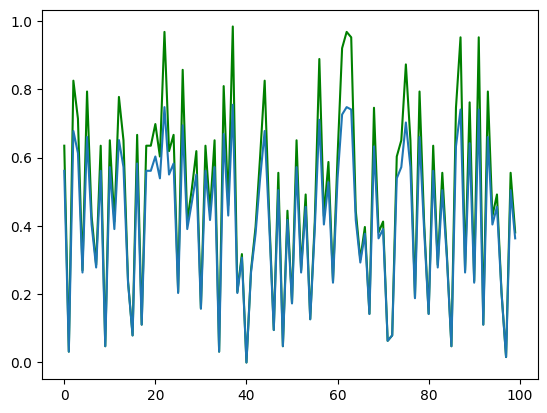

In [59]:
size = 100
y = np.random.randint(low=0, high=63, size=size)/63

x = np.arange(0, size, 1, dtype=int)
plt.plot(x,y, color='green',)
y = np.tanh(y)
plt.plot(x,y)

In [60]:
agent_irp = IRPAgent(node_dim=node_dim,
            seed=seed, csv_path=f"./train_logs/my_loss_log_irp_{num_nodes}_{seed}.csv",)

In [ ]:
import time
loss_history, rem_time_history, k_vehicles_history, kpi = train(agent_irp,
            train_dataloader,
            batch_size=batch_size,
            k_vehicles=k_vehicles,
            epochs=100,
            max_trips=2,
            check_point_dir=f"./check_points/my_irp_{num_nodes}_{seed}/",)

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-33-06376a48975b>:268: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  exceed_time = np.where(np.all(self.cur_remaining_time <= 0, axis=0))[0]
<ipython-input-33-06376a48975b>:276: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  exceed_vehicles = np.where(np.all(self.vehicles <= 0, axis=0))[0]
  3%|▎         | 3/100 [00:36<20:43, 12.82s/it]

replacing baceline


  5%|▌         | 5/100 [01:07<21:46, 13.75s/it]

In [ ]:
import matplotlib.pyplot as plt

loss_history = torch.tensor(loss_history)
rem_time_history = torch.tensor(rem_time_history)
k_vehicles_history = torch.tensor(k_vehicles_history)

linspace = np.array(range(len(loss_history)))
plt.plot(linspace, loss_history.numpy())

In [ ]:
plt.plot(linspace, rem_time_history.numpy())

In [ ]:
plt.plot(linspace, k_vehicles_history.numpy())

### Pred on CPSAT

In [ ]:
# num_nodes = 10
# synth_data = create_wheel_noised(num_nodes)
# data_nn, data_cpsat = get_graph_dict(synth_data,
#                                      num_nodes,
#                                      products_count,
#                                      compartment_capacity,
#                                      7,
#                                      k_vehicles=k_vehicles,
#                                      noise_demand=0.0,
#                                      draw=True)

data_nn = dataset[0]
data_cpsat = dataset.model_for_cpsat

In [ ]:
import time
task_builder = TaskBuilder_MPPSRP_FullMILP_CPSAT( max_trips_per_day=2, verbose=True )
task = task_builder.build_task( data_cpsat )

print("Dataset name: {}".format( dataset_name ))
print("Solving start time: {}".format( datetime.now() ))
task_solver = TaskSolver_MPPSRP_CPSAT( cache_dir=interim_dir,
                                       cache_all_feasible_solutions=False,
                                       solution_prefix=dataset_name,
                                       time_limit_milliseconds=300_000)
start_time = time.time()
solution = task_solver.solve( task )
delta_time = time.time() - start_time
print('kpi')
kpi_dict = solution.get_kpis()
pprint( kpi_dict )

print()
routes_schedule = solution.get_routes_schedule()
pprint( routes_schedule )

print("done")

### Pred on model

In [ ]:
item = dataset[0]
new_item = []
for i in range(len(item)):
  new_item.append(np.expand_dims(item[i], axis=0))

In [ ]:
import time
from copy import deepcopy

temp_data = deepcopy(new_item)
# batch = [np.expand_dims(temp_data['positions'], axis=0),\
#           np.expand_dims(temp_data['travel_time_matrix'], axis=0), \
#           np.expand_dims(temp_data['node_demand'], axis=0),\
#           np.expand_dims(temp_data['depots'], axis=0),\
#           np.expand_dims(temp_data['vehicle_time_windows'], axis=0),\
#           np.expand_dims(temp_data['restriction_matrix'], axis=0),\
#           np.expand_dims(temp_data['service_times'], axis=0),\
#           np.expand_dims(temp_data['min_capacities'], axis=0),\
#           np.expand_dims(temp_data['max_capacities'], axis=0),\
#           np.expand_dims(temp_data['init_capacities'], axis=0)]





env_irp = IRPEnv_Custom(temp_data,
                        num_depots=num_depots,
                        num_nodes=num_nodes,
                        batch_size=1,
                        k_vehicles=10,
                        products_count=products_count,
                        seed=seed)

start_time = time.time()
loss_a, actions_list, kpi = agent_irp.evaluate(env_irp)
delta_time_model = time.time() - start_time
print(loss_a)

In [ ]:
actions = [e.item() for e in actions_list]
m = data_cpsat['distance_matrix']
t = data_cpsat['travel_time_matrix']

time_delta = 18*60*60 - 9*60*60

sum_dist = 0
sum_time = 0
global_sum_time = 0
exceeded_time = 0
actions.insert(0,0)
print(actions)
for i in range(len(actions)-1):
  start = actions[i]
  end = actions[i+1]
  dist = m[start][end]
  edge_time = t[start][end]
  sum_time += edge_time
  global_sum_time += edge_time
  sum_dist += dist

  if end == 0 and sum_time > time_delta:
    #print(start, end)
    exceeded_time += 1
    sum_time = 0
  #print(f'{start} -> {end} : dist = {dist} time = {edge_time}')

print()
print(f'sum_dist={sum_dist}, sum_time={global_sum_time}, exceeded_time = {exceeded_time}')

In [ ]:

nn_paths = divide_to_paths_nn(actions)
lengths = []
for e in nn_paths:
  if not np.all(np.array(e) == 0):
    lengths.append(len(e))
np.array(lengths).mean()

In [ ]:
kpi['mean_stops'] = np.array(lengths).mean()

In [ ]:
kpi['avarage_stocks']

In [ ]:
kpi['dry_runs']

In [ ]:
actions_daily = kpi['actions_daily']
for key in actions_daily:
  actions_daily[key] =[e.item() for e in actions_daily[key]]

In [ ]:
kpi['dry_runs'].values()

In [ ]:
result['wheel_10_3'] = {
        'sum_dist_cpsat':kpi_dict['total_travel_distance'],
        'sum_dist_model':sum_dist,
        'error': (kpi_dict['total_travel_distance'] - sum_dist) / kpi_dict['total_travel_distance'],
        'time_cpsat':delta_time,
        'time_model':delta_time_model,
        'dry_runs_model':sum(list(kpi['dry_runs'].values())),
        'dry_runs_cpsat':kpi_dict['dry_runs'],
    }
pd.DataFrame.from_dict(result, orient='index',).round(3)

In [ ]:

nn_paths = divide_to_paths_nn(actions_daily[0.0])
print(len(nn_paths))
draw_paths(data_nn, nn_paths)

In [ ]:

nn_paths = divide_to_paths_nn(actions_daily[1.0])
print(len(nn_paths))
draw_paths(data_nn, nn_paths)

In [ ]:
nn_paths = divide_to_paths_nn(actions_daily[3.0])
print(len(nn_paths))
draw_paths(data_nn, nn_paths)

In [ ]:
nn_paths = divide_to_paths_nn(actions_daily[4.0])
print(len(nn_paths))
draw_paths(data_nn, nn_paths)

In [ ]:
nn_paths = divide_to_paths_nn(actions_daily[5.0])
print(len(nn_paths))
draw_paths(data_nn, nn_paths)

In [ ]:
nn_paths = divide_to_paths_nn(actions_daily[6.0])
print(len(nn_paths))
draw_paths(data_nn, nn_paths)

In [ ]:
actions_daily

In [ ]:
nn_paths = divide_to_paths_nn(actions_daily[7.0])
print(len(nn_paths))
draw_paths(data_nn, nn_paths)

In [ ]:
cpsat_path = divide_to_path_cpsat(routes_schedule)
draw_paths(data_nn, cpsat_path)

## Node count = 20, wheel graphs

### Generate data

In [ ]:
num_nodes = 20
products_count = 3
compartment_capacity = 50
dir = '/content/drive/MyDrive/GraphDataset/wheel_20/'

In [ ]:
generate_dataset(create_wheel_noised,
                 num_nodes=num_nodes,
                 num_graphs=100,
                 compartment_capacity=compartment_capacity,
                 products_count=products_count,
                 dataset_dir = dir)

### Learn model

In [ ]:
files = os.listdir(dir)
dataset = [load(Path(dir, file)) for file in files[0:100]]

seed = 69
num_node = dataset[0]['num_nodes']
node_dim = dataset[0]['products_count'] + 2
batch_size=100

agent_irp = IRPAgent(node_dim=node_dim,
            seed=seed, csv_path=f"./train_logs/my_loss_log_irp_{num_node}_{seed}.csv",)

train(agent_irp,
            dataset,
            batch_size=batch_size,
            epochs=20,
            check_point_dir=f"./check_points/my_irp_{num_node}_{seed}/",)

### Pred on CPSAT

In [ ]:
synth_data = create_wheel_noised(num_nodes)
data_nn, data_cpsat = get_graph_dict(synth_data,
                                     num_nodes,
                                     products_count,
                                     compartment_capacity,
                                     planning_horizon,
                                     noise_demand=0.2,
                                     draw=True)

In [ ]:
task_builder = TaskBuilder_MPPSRP_FullMILP_CPSAT( max_trips_per_day=100, verbose=True )
task = task_builder.build_task( data_cpsat )

print("Dataset name: {}".format( dataset_name ))
print("Solving start time: {}".format( datetime.now() ))
task_solver = TaskSolver_MPPSRP_CPSAT( cache_dir=interim_dir,
                                       cache_all_feasible_solutions=False,
                                       solution_prefix=dataset_name,
                                       time_limit_milliseconds=300_000 )
start_time = time.time()
solution = task_solver.solve( task )
delta_time = time.time() - start_time
print('kpi')
kpi_dict = solution.get_kpis()
pprint( kpi_dict )

print()
routes_schedule = solution.get_routes_schedule()
pprint( routes_schedule )

print("done")

### Pred on model

In [ ]:
seed = 69

VRPNetwork = VRPNetwork_Synthetic([data_nn], 1)
env_irp = IRPEnv_Custom(VRPNetwork, seed=seed, num_draw=1)

start_time = time.time()
loss_a, actions_list = agent_irp.evaluate(env_irp)
delta_time_model = time.time() - start_time
print(loss_a)

a = env_irp.render()

In [ ]:
actions = [e.item() for e in actions_list]
m = synth_data['weight_matrix']

sum_dist = 0
actions.insert(0,0)
print(actions)
for i in range(len(actions)-1):
  start = actions[i]
  end = actions[i+1]
  dist = m[start][end]
  sum_dist += dist
  print(f'{start} -> {end} = {dist}')

sum_dist

In [ ]:
result['wheel_20_3'] = {
        'sum_dist_cpsat':kpi_dict['total_travel_distance'],
        'sum_dist_model':sum_dist,
        'error': (kpi_dict['total_travel_distance'] - sum_dist) / kpi_dict['total_travel_distance'],
        'time_cpsat':delta_time,
        'time_model':delta_time_model,
    }
pd.DataFrame.from_dict(result, orient='index',).round(3)

In [ ]:
nn_paths = divide_to_paths_nn(actions)
cpsat_path = divide_to_path_cpsat(routes_schedule)
draw_paths(data_nn, nn_paths)

In [ ]:
draw_paths(data_nn, cpsat_path)

## Node count = 8, tree graphs

### Generate data

In [ ]:
num_nodes = 8
num_gen_nodes = int(math.log2(num_nodes))
products_count = 3
compartment_capacity = 50
dir = '/content/drive/MyDrive/GraphDataset/tree_50/'

In [ ]:
generate_dataset(create_tree_noised,
                 num_nodes=num_gen_nodes,
                 num_graphs=300,
                 compartment_capacity=compartment_capacity,
                 products_count=products_count,
                 dataset_dir = dir,
                 noise_demand=0.2,
                 draw=False)

### Learn model

In [ ]:
files = os.listdir(dir)
dataset = [load(Path(dir, file)) for file in files[0:300]]
print(dataset[0]['products_count'])

seed = 70
num_node = dataset[0]['num_nodes']
node_dim = dataset[0]['products_count'] + 2
batch_size=100

agent_irp = IRPAgent(node_dim=node_dim,
            seed=seed, csv_path=f"./train_logs/my_loss_log_irp_{num_node}_{seed}.csv",)

train(agent_irp,
            dataset,
            batch_size=batch_size,
            epochs=150,
            check_point_dir=f"./check_points/my_irp_{num_node}_{seed}/",)

### Pred on CPSAT

In [ ]:
synth_data = create_tree_noised(num_gen_nodes)
data_nn, data_cpsat = get_graph_dict(synth_data,
                                     num_nodes,
                                     products_count,
                                     compartment_capacity,
                                     planning_horizon,
                                     noise_demand=0.2,
                                     draw=True)

In [ ]:
task_builder = TaskBuilder_MPPSRP_FullMILP_CPSAT( max_trips_per_day=100, verbose=True )
task = task_builder.build_task( data_cpsat )

print("Dataset name: {}".format( dataset_name ))
print("Solving start time: {}".format( datetime.now() ))
task_solver = TaskSolver_MPPSRP_CPSAT( cache_dir=interim_dir,
                                       cache_all_feasible_solutions=False,
                                       solution_prefix=dataset_name,
                                       time_limit_milliseconds=300_000 )
start_time = time.time()
solution = task_solver.solve( task )
delta_time = time.time() - start_time
print('kpi')
kpi_dict = solution.get_kpis()
pprint( kpi_dict )

print()
routes_schedule = solution.get_routes_schedule()
pprint( routes_schedule )

print("done")

### Pred on model

In [ ]:
seed = 69

VRPNetwork = VRPNetwork_Synthetic([data_nn], num_depots=1)
env_irp = IRPEnv_Custom(VRPNetwork, seed=seed, num_draw=1)

start_time = time.time()
loss_a, actions_list = agent_irp.evaluate(env_irp)
delta_time_model = time.time() - start_time
print(loss_a)

a = env_irp.render()

In [ ]:
actions = [e.item() for e in actions_list]
m = synth_data['weight_matrix']

sum_dist = 0
actions.insert(0,0)
print(actions)
for i in range(len(actions)-1):
  start = actions[i]
  end = actions[i+1]
  dist = m[start][end]
  sum_dist += dist
  print(f'{start} -> {end} = {dist}')

sum_dist

In [ ]:
result[f'tree_{num_nodes}_{products_count}'] = {
        'sum_dist_cpsat':kpi_dict['total_travel_distance'],
        'sum_dist_model':sum_dist,
        'error': (kpi_dict['total_travel_distance'] - sum_dist) / kpi_dict['total_travel_distance'],
        'time_cpsat':delta_time,
        'time_model':delta_time_model,
    }
pd.DataFrame.from_dict(result, orient='index',).round(3)

In [ ]:
nn_paths = divide_to_paths_nn(actions)
cpsat_path = divide_to_path_cpsat(routes_schedule)
draw_paths(data_nn, nn_paths)

In [ ]:
draw_paths(data_nn, cpsat_path)

## Node count = 16, tree graphs

### Generate data

In [ ]:
num_nodes = 16
num_gen_nodes = int(math.log2(num_nodes))
products_count = 3
compartment_capacity = 50
dir = '/content/drive/MyDrive/GraphDataset/tree_64/'

In [ ]:
generate_dataset(create_tree_noised,
                 num_nodes=num_gen_nodes,
                 num_graphs=100,
                 compartment_capacity=compartment_capacity,
                 products_count=products_count,
                 dataset_dir = dir,
                 draw=False)

### Learn model

In [ ]:
files = os.listdir(dir)
dataset = [load(Path(dir, file)) for file in files[0:100]]

seed = 69
num_node = dataset[0]['num_nodes']
node_dim = dataset[0]['products_count'] + 2
batch_size=100

agent_irp = IRPAgent(node_dim=node_dim,
            seed=seed, csv_path=f"./train_logs/my_loss_log_irp_{num_node}_{seed}.csv",)

train(agent_irp,
            dataset,
            batch_size=batch_size,
            epochs=100,
            check_point_dir=f"./check_points/my_irp_{num_node}_{seed}/",)

### Pred on CPSAT

In [ ]:
synth_data = create_tree_noised(num_gen_nodes)
data_nn, data_cpsat = get_graph_dict(synth_data,
                                     num_nodes,
                                     products_count,
                                     compartment_capacity,
                                     planning_horizon,
                                     noise_demand=0.2,
                                     draw=True)

In [ ]:
task_builder = TaskBuilder_MPPSRP_FullMILP_CPSAT( max_trips_per_day=100, verbose=True )
task = task_builder.build_task( data_cpsat )

print("Dataset name: {}".format( dataset_name ))
print("Solving start time: {}".format( datetime.now() ))
task_solver = TaskSolver_MPPSRP_CPSAT( cache_dir=interim_dir,
                                       cache_all_feasible_solutions=False,
                                       solution_prefix=dataset_name,
                                       time_limit_milliseconds=300_000 )
start_time = time.time()
solution = task_solver.solve( task )
delta_time = time.time() - start_time
print('kpi')
kpi_dict = solution.get_kpis()
pprint( kpi_dict )

print()
routes_schedule = solution.get_routes_schedule()
pprint( routes_schedule )

print("done")

### Pred on model

In [ ]:
seed = 69

VRPNetwork = VRPNetwork_Synthetic([data_nn], 1)
env_irp = IRPEnv_Custom(VRPNetwork, seed=seed, num_draw=1)

start_time = time.time()
loss_a, actions_list = agent_irp.evaluate(env_irp)
delta_time_model = time.time() - start_time
print(loss_a)

a = env_irp.render()

In [ ]:
actions = [e.item() for e in actions_list]
m = synth_data['weight_matrix']

sum_dist = 0
actions.insert(0,0)
print(actions)
for i in range(len(actions)-1):
  start = actions[i]
  end = actions[i+1]
  dist = m[start][end]
  sum_dist += dist
  print(f'{start} -> {end} = {dist}')

sum_dist

In [ ]:
result['tree_16_3'] = {
        'sum_dist_cpsat':kpi_dict['total_travel_distance'],
        'sum_dist_model':sum_dist,
        'error': (kpi_dict['total_travel_distance'] - sum_dist) / kpi_dict['total_travel_distance'],
        'time_cpsat':delta_time,
        'time_model':delta_time_model,
    }
pd.DataFrame.from_dict(result, orient='index',).round(3)

In [ ]:
nn_paths = divide_to_paths_nn(actions)
cpsat_path = divide_to_path_cpsat(routes_schedule)
draw_paths(data_nn, nn_paths)

In [ ]:
draw_paths(data_nn, cpsat_path)

## Node count = 16, grid graphs

### Generate data

In [ ]:
num_nodes = 16
num_gen_nodes = int(math.log2(num_nodes))
products_count = 3
compartment_capacity = 50
dir = '/content/drive/MyDrive/GraphDataset/grid_16/'

In [ ]:
generate_dataset(create_grid_noised,
                 num_nodes=num_gen_nodes,
                 num_graphs=100,
                 compartment_capacity=compartment_capacity,
                 products_count=products_count,
                 dataset_dir = dir,
                 draw=False)

### Learn model

In [ ]:
files = os.listdir(dir)
dataset = [load(Path(dir, file)) for file in files[0:100]]

seed = 69
num_node = dataset[0]['num_nodes']
node_dim = dataset[0]['products_count'] + 2
batch_size=100

agent_irp = IRPAgent(node_dim=node_dim,
            seed=seed, csv_path=f"./train_logs/my_loss_log_irp_{num_node}_{seed}.csv",)

train(agent_irp,
            dataset,
            batch_size=batch_size,
            epochs=100,
            check_point_dir=f"./check_points/my_irp_{num_node}_{seed}/",)

### Pred on CPSAT

In [ ]:
synth_data = create_grid_noised(num_gen_nodes)
data_nn, data_cpsat = get_graph_dict(synth_data,
                                     num_nodes,
                                     products_count,
                                     compartment_capacity,
                                     planning_horizon,
                                     noise_demand=0.2,
                                     draw=True)

In [ ]:
task_builder = TaskBuilder_MPPSRP_FullMILP_CPSAT( max_trips_per_day=100, verbose=True )
task = task_builder.build_task( data_cpsat )

print("Dataset name: {}".format( dataset_name ))
print("Solving start time: {}".format( datetime.now() ))
task_solver = TaskSolver_MPPSRP_CPSAT( cache_dir=interim_dir,
                                       cache_all_feasible_solutions=False,
                                       solution_prefix=dataset_name,
                                       time_limit_milliseconds=6000_000 )
start_time = time.time()
solution = task_solver.solve( task )
delta_time = time.time() - start_time
print('kpi')
kpi_dict = solution.get_kpis()
pprint( kpi_dict )

print()
routes_schedule = solution.get_routes_schedule()
pprint( routes_schedule )

print("done")

### Pred on model

In [ ]:
seed = 69

VRPNetwork = VRPNetwork_Synthetic([data_nn], 1)
env_irp = IRPEnv_Custom(VRPNetwork, seed=seed, num_draw=1)

start_time = time.time()
loss_a, actions_list = agent_irp.evaluate(env_irp)
delta_time_model = time.time() - start_time
print(loss_a)

a = env_irp.render()

In [ ]:
actions = [e.item() for e in actions_list]
m = synth_data['weight_matrix']

sum_dist = 0
actions.insert(0,0)
print(actions)
for i in range(len(actions)-1):
  start = actions[i]
  end = actions[i+1]
  dist = m[start][end]
  sum_dist += dist
  print(f'{start} -> {end} = {dist}')

sum_dist

In [ ]:
result['grid_16_3'] = {
        'sum_dist_cpsat':kpi_dict['total_travel_distance'],
        'sum_dist_model':sum_dist,
        'error': (kpi_dict['total_travel_distance'] - sum_dist) / kpi_dict['total_travel_distance'],
        'time_cpsat':delta_time,
        'time_model':delta_time_model,
    }
pd.DataFrame.from_dict(result, orient='index',).round(3)

In [ ]:
nn_paths = divide_to_paths_nn(actions)
cpsat_path = divide_to_path_cpsat(routes_schedule)
draw_paths(data_nn, nn_paths)

In [ ]:
draw_paths(data_nn, cpsat_path)

# Compartments

In [ ]:
graph_generator = GraphGenerator()

g = graph_generator.build_graph( 10, graph_type="wheel", layout="kamada-kawai")
g = graph_generator.alter_graph( g, shift=(1.3, 1.3), scale=(100.0, 100.0), rotation_angle=0, convert_to_int=True )
g = graph_generator.init_edge_weights( g, round_to = 1 )
weight_matrix = graph_generator.build_edge_weight_matrix(g, fill_empty_policy ="shortest", make_int=True)


dataset_name = "wheel_prime_10"
graph_generator.plot_graph( g, with_labels=True, with_edge_labels=True )
#plt.show()
plt.savefig( Path( images_dir, "{}.jpg".format( dataset_name ) ), dpi=1000 )
graph_data = {}
graph_data["graph"] = g
graph_data["weight_matrix"] = weight_matrix
save( graph_data, Path( graphs_dir, "{}.pkl".format( dataset_name ) ))

print("done")

In [ ]:
dataset_name = "wheel_prime_10"
#dataset_name = "wheel_noised_10"
#dataset_name = "wheel_prime_21"
#dataset_name = "wheel_noised_21"
#dataset_name = "wheel_10_ring_20"
#dataset_name = "grid_noised_49"
#dataset_name = "grid_noised_64"
#dataset_name = "tree_prime_4"
#dataset_name = "tree_prime_5"
#dataset_name = "tree_noised_5"
#dataset_name = "mix_prime_78"
#dataset_name = "mix_noised_78"
#dataset_name = "moskow_prime_248"
#dataset_name = "moskow_noised_248"
#dataset_name = "moskow_prime_380"
#dataset_name = "moskow_noised_380"
synth_data = load( Path( graphs_dir, "{}.pkl".format( dataset_name ) ) )

data_builder = DataBuilder_MPPSRP_Simple(synth_data["weight_matrix"],
                                         distance_multiplier=1, travel_time_multiplier=60*60,
                                         planning_horizon=7,
                                         safety_level=0.05, max_level=0.95,
                                         initial_inventory_level=0.5, tank_capacity=100,
                                         depot_service_time = 15*60, station_service_time=10*60,
                                         demand=10, products_count=2,
                                         k_vehicles=13, compartments=[5 * [50]],
                                         mean_vehicle_speed=60, vehicle_time_windows=[[9*60*60, 18*60*60]],
                                         noise_initial_inventory=0.2, noise_tank_capacity=0.2,
                                         noise_compartments=0.2, noise_demand=0.2,
                                         noise_vehicle_time_windows=0.0,
                                         noise_restrictions = 0.0,
                                         random_seed=45)
data_model = data_builder.build_data_model()

task_builder = TaskBuilder_MPPSRP_FullMILP_CPSAT( max_trips_per_day=2, verbose=True )
task = task_builder.build_task( data_model )

print("Dataset name: {}".format( dataset_name ))
print("Solving start time: {}".format( datetime.now() ))
task_solver = TaskSolver_MPPSRP_CPSAT( cache_dir=interim_dir,
                                       cache_all_feasible_solutions=False,
                                       solution_prefix=dataset_name,
                                       time_limit_milliseconds=120_000 )
solution = task_solver.solve( task )

print()
kpi_dict = solution.get_kpis()
pprint( kpi_dict )

print()
routes_schedule = solution.get_routes_schedule()
pprint( routes_schedule )

print("done")

## Print shapes

### Generate data

In [ ]:
num_nodes = 10
products_count = 3
compartment_capacity = 50
planning_horizon = 1
dir = '/content/drive/MyDrive/GraphDataset/wheel_10/'

In [ ]:
generate_dataset(create_wheel_noised,
                 num_nodes=num_nodes,
                 num_graphs=100,
                 compartment_capacity=compartment_capacity,
                 products_count=products_count,
                 dataset_dir = dir,
                 del_previous_dir=True)

### Learn model

In [ ]:
files = os.listdir(dir)
dataset = [load(Path(dir, file)) for file in files[0:2]]

seed = 70
num_node = dataset[0]['num_nodes']
node_dim = dataset[0]['products_count'] + 2
batch_size=2

agent_irp = IRPAgent(node_dim=node_dim,
            seed=seed, csv_path=f"./train_logs/my_loss_log_irp_{num_node}_{seed}.csv",)

train(agent_irp,
            dataset,
            batch_size=batch_size,
            epochs=1,
            check_point_dir=f"./check_points/my_irp_{num_node}_{seed}/",)

In [ ]:
a = torch.ones((2, 1, 128))

b = torch.ones((2, 1, 128))

c = torch.ones((2, 1, 100))

context = torch.cat([a, b, c], -1)
context.shape

In [ ]:
probs = torch.tensor([[[   float('-inf'),  0.0185,  0.4894, -0.3443, -0.4399]],

        [[   float('-inf'), -0.0842,  0.2667, -0.4489, -0.2583]]])

In [ ]:
probs

In [ ]:
probs = torch.rand((2,2,10))
m = Categorical(logits=probs)

In [ ]:
nn_idx = m.sample()
nn_idx

In [ ]:
m.log_prob(nn_idx)

In [ ]:
m.enumerate_support()

### Pred on CPSAT

In [ ]:
synth_data = create_wheel_noised(num_nodes)
data_nn, data_cpsat = get_graph_dict(synth_data,
                                     num_nodes,
                                     products_count,
                                     compartment_capacity,
                                     planning_horizon,
                                     noise_demand=0.2,
                                     draw=True)

In [ ]:
task_builder = TaskBuilder_MPPSRP_FullMILP_CPSAT( max_trips_per_day=100, verbose=True )
task = task_builder.build_task( data_cpsat )

print("Dataset name: {}".format( dataset_name ))
print("Solving start time: {}".format( datetime.now() ))
task_solver = TaskSolver_MPPSRP_CPSAT( cache_dir=interim_dir,
                                       cache_all_feasible_solutions=False,
                                       solution_prefix=dataset_name,
                                       time_limit_milliseconds=300_000)
start_time = time.time()
solution = task_solver.solve( task )
delta_time = time.time() - start_time
print('kpi')
kpi_dict = solution.get_kpis()
pprint( kpi_dict )

print()
routes_schedule = solution.get_routes_schedule()
pprint( routes_schedule )

print("done")

### Pred on model

In [ ]:
seed = 69

VRPNetwork = VRPNetwork_Synthetic([data_nn], 1)
env_irp = IRPEnv_Custom(VRPNetwork, seed=seed, num_draw=1)

start_time = time.time()
loss_a, actions_list = agent_irp.evaluate(env_irp)
delta_time_model = time.time() - start_time
print(loss_a)

a = env_irp.render()

In [ ]:
actions = [e.item() for e in actions_list]
m = synth_data['weight_matrix']

sum_dist = 0
actions.insert(0,0)
print(actions)
for i in range(len(actions)-1):
  start = actions[i]
  end = actions[i+1]
  dist = m[start][end]
  sum_dist += dist
  print(f'{start} -> {end} = {dist}')

sum_dist

In [ ]:
result['wheel_10_3'] = {
        'sum_dist_cpsat':kpi_dict['total_travel_distance'],
        'sum_dist_model':sum_dist,
        'error': (kpi_dict['total_travel_distance'] - sum_dist) / kpi_dict['total_travel_distance'],
        'time_cpsat':delta_time,
        'time_model':delta_time_model,
    }
pd.DataFrame.from_dict(result, orient='index',).round(3)

In [ ]:
nn_paths = divide_to_paths_nn(actions)
cpsat_path = divide_to_path_cpsat(routes_schedule)
draw_paths(data_nn, nn_paths)

In [ ]:
draw_paths(data_nn, cpsat_path)

In [ ]:
data_model

In [ ]:
torch.set_printoptions(precision=3)